In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)
# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

import seaborn as sns
from scipy.signal import savgol_filter

2023-06-26 15:14:02.231635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:14:03.956823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-26 15:14:03.957022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-26 15:14:03.957044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  1


2023-06-26 15:14:06.846476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 15:14:06.911306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 15:14:06.911911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Loading the data
telem_path = r"../../telemetry-files/funcube-1/funcube-1-telemetry-2016-02-10.h5"
telem_df = pd.read_hdf(
    telem_path,
    "telem",
)
telem_df["illumination"] = telem_df.apply(lambda row: 1 if row["theta_T (deg)"] < (360 * (1 - row["fe"])) else 0, axis=1)


# Processing telem_df for constant values:
telem_processed_df = telem_df.copy()
prev_row = telem_df.iloc[0]
for i, row in telem_df.iterrows():
    if i == 0:
        continue
    if row.iloc[6:14].equals(prev_row.iloc[6:14]):
        telem_processed_df.drop(i, inplace=True)
    prev_row = row
        
telem_processed_df = telem_processed_df.reset_index(drop=True)

telem_processed_df.head()
# Add illumination column:
# telem_processed_df["illumination"] = telem_processed_df.apply(lambda row: 1 if row["theta_T (deg)"] < (360 * (1 - row["fe"])) else 0, axis=1)

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2016-02-04 00:00:00.000  2.457422e+06   43.419578  0.314142   287.512192   
1  2016-02-04 00:01:00.000  2.457423e+06   43.419238  0.313883   291.258857   
2  2016-02-04 00:02:00.000  2.457423e+06   43.418972  0.313594   295.003917   
3  2016-02-04 00:03:00.000  2.457423e+06   43.418786  0.313277   298.747190   
4  2016-02-04 00:04:00.000  2.457423e+06   43.418684  0.312933   302.488507   

   theta_T (deg)  black chassis temperature (deg C)  \
0      50.966681                               1.23   
1      54.759942                               1.47   
2      58.556932                               0.00   
3      62.357285                               1.68   
4      66.160507                               3.65   

   silver chassis temperature (deg C)  black panel temperature (deg C)  \
0                               -0.85                            -2.10   
1                                1.17                             2.75   
2                                2.44                             7.00   
3                                1.81                             4.38   
4                                2.77                             6.23   

   silver panel temperature (deg C)  solar panel +X temperature (deg C)  \
0                              2.23                                3.39   
1                              5.04                                0.69   
2                              8.09                               -1.80   
3                              5.67                                2.97   
4                              6.31                                2.14   

   solar panel -X temperature (deg C)  solar panel +Y temperature (deg C)  \
0                               -2.41                               -1.40   
1                                0.92                                2.75   
2                                3.84                               -0.57   
3                                0.50                               -1.40   
4                                0.50                                3.79   

   solar panel -Y temperature (deg C)  illumination  
0                                0.43             1  
1                               -2.91             1  
2                                1.89             1  
3                                3.77             1  
4                                0.22             1

In [3]:
def normalize_temperature(temps, limits=None):
    """
    Function to normalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be normalized.
    :param limits: Limits of the temperature data. If None, the limits are calculated from the data.

    :return: Normalized temperature data.
    """
    
    if limits is None:
        limits = np.array([np.min(temps), np.max(temps)])

    return (temps - limits[0]) / (limits[1] - limits[0])

def denormalize_temperature(temps, limits):
    """
    Function to denormalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be denormalized.
    :param limits: Limits of the temperature data.

    :return: Denormalized temperature data.
    """

    return temps * (limits[1] - limits[0]) + limits[0]

In [4]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, labels=None, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param bins: Number of bins to be used for the KDE.
    :param plot_kde: Boolean to plot the KDE.
    :param labels: Labels of the KDE plots.

    :return: kde, bin_centers
    """

    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the KDE values
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the bin centers
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])  # kernel density estimate function
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)  # bin centers
        kde[i, :] = kde_func(bin_centers[i])    # KDE values

    if plot_kde:
        plt.figure(figsize=(6, 5), tight_layout=True)
        for i in range(data.shape[1]):
            plt.plot(
                bin_centers[i],
                kde[i],
                color=plt_colors[i],
                label=labels[i] if labels is not None else None,
            )

        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density ($^\circ$C$^{-1}$)")
        if plt_title is None:
            plt_title = "Kernel density estimate of the errors"
        plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    return kde, bin_centers



def print_kde_stats(data, kde, bin_centers):
    """
    Function to print the mean, standard deviation and area under the KDE curve of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param kde: KDE values.
    :param bin_centers: Bin centers.

    :return: None
    """

    print("Battery:")
    print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
    print("Solar panel Yp:")
    print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
    print("Solar panel Ym:")
    print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
    print("Solar panel Xp:")
    print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
    print("Solar panel Xm:")
    print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
    print("MCU:")
    print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")


In [5]:
def plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=None,
    labels=None,
    colors=None,
    plt_scatter=None,
    linestyles=None,
    limits=None,
    plt_suptitle=None,
):
    """Plots the temperature values of the model.

    Parameters
    ----------
    theta_T_vals : list of numpy.ndarray
        List of theta_T values for each model.
    temp_vals : list of numpy.ndarray
        List of temperature values for each model.
    plt_titles : list of str, optional
        List of titles for each subplot, by default None
    labels : list of str, optional
        List of labels for each model, by default None
    colors : list of mpl colors, optional
        List of colors for each model, by default None
    plt_scatter : list of bool, optional
        List of bools to indicate if the model should be plotted as a scatter plot, by default None
    linestyles : list of str, optional
        List of linestyles for each model, by default None
    limits : list of list of float, optional
        List of limits for each axis, by default None
    plt_suptitle : str, optional
        Title for the figure, by default None
    """

    plt_rows = 2
    plt_cols = 4

    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols * 5, plt_rows * 5))

    for i in range(plt_rows):
        for j in range(plt_cols):
            for k in range(len(theta_T_vals)):
                if plt_scatter[k]:
                    ax[i, j].scatter(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        s=2,
                    )
                else:
                    ax[i, j].plot(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        linestyle=linestyles[k] if linestyles is not None else "-",
                    )

            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * plt_cols + j] if plt_titles is not None else None)
            ax[i, j].legend(fontsize=8)
            if limits is not None:
                ax[i, j].set_xlim(limits[0])
                ax[i, j].set_ylim(limits[1])

            ax[i, j].grid()

    if plt_suptitle is not None:
        fig.suptitle(plt_suptitle, fontsize=12)

    return fig, ax

In [6]:
# Test/train split
train_df = telem_processed_df.iloc[:int(0.8 * len(telem_processed_df))].reset_index(drop=True)
test_df = telem_processed_df.iloc[int(0.8 * len(telem_processed_df)):].reset_index(drop=True)

train_norm_df = train_df.copy()
norm_limits = [np.min(train_norm_df.iloc[:, 6:-1].to_numpy()), np.max(train_norm_df.iloc[:, 6:-1].to_numpy())]
train_norm_df.iloc[:, 6:-1] = normalize_temperature(train_norm_df.iloc[:, 6:-1].to_numpy(), norm_limits)

test_norm_df = test_df.copy()
test_norm_df.iloc[:, 6:-1] = normalize_temperature(test_norm_df.iloc[:, 6:-1].to_numpy(), norm_limits)

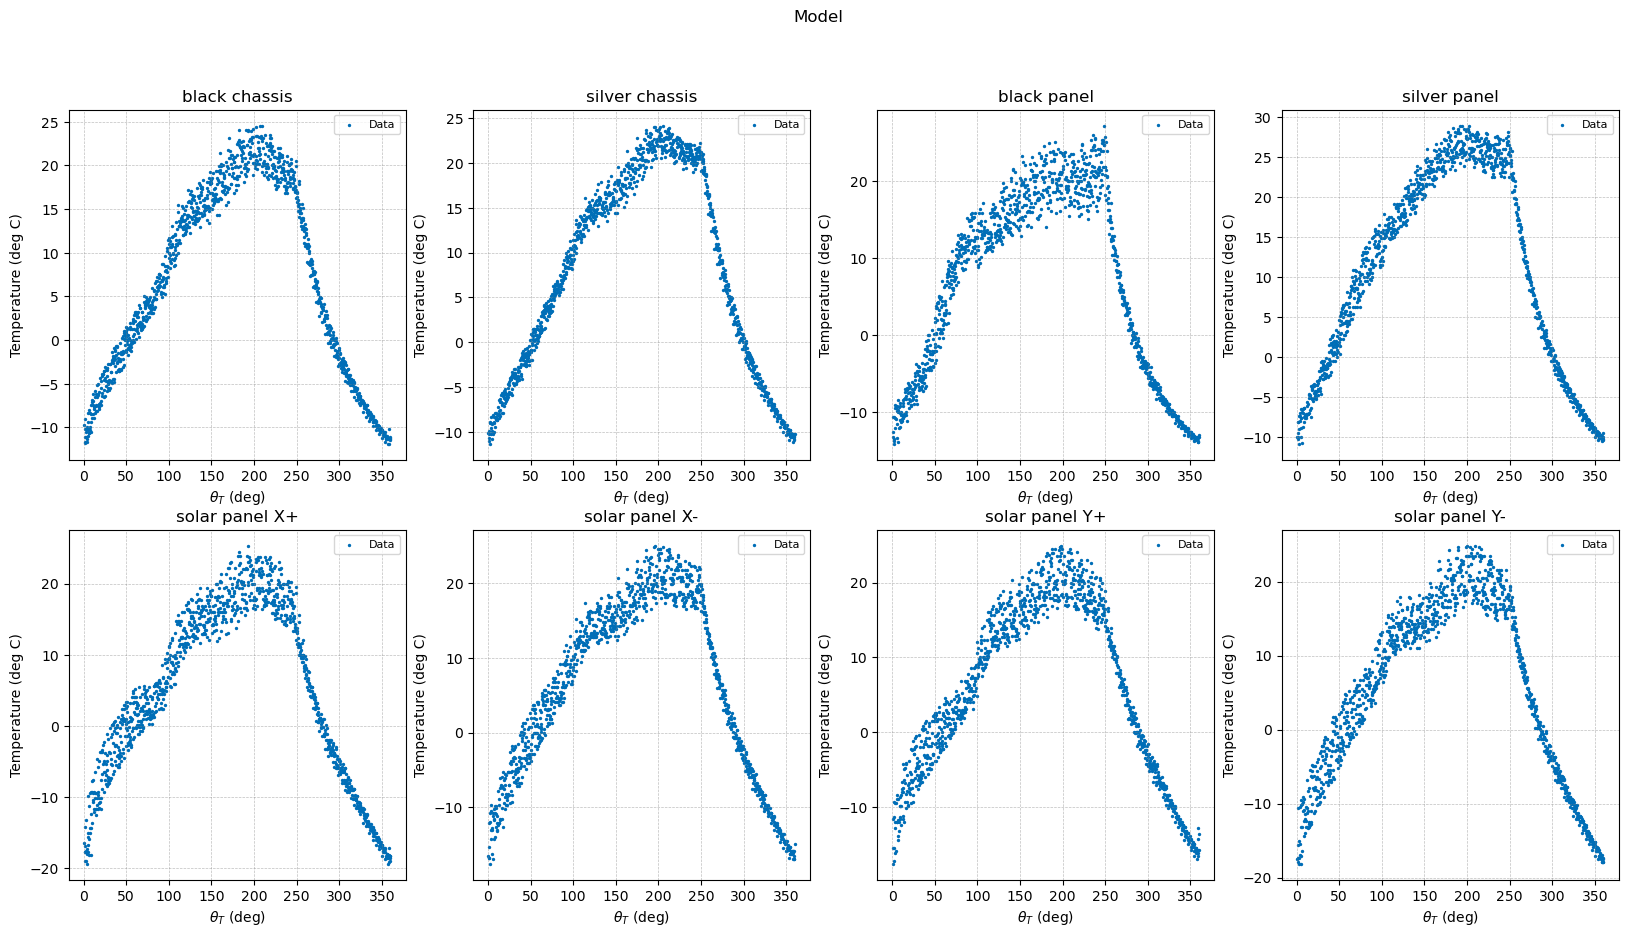

In [7]:
theta_T_vals = [telem_processed_df["theta_T (deg)"]]
temp_vals = [telem_processed_df.iloc[:, 6:-1].to_numpy()]
plt_titles = ["black chassis", "silver chassis", "black panel", "silver panel", "solar panel X+", "solar panel X-", "solar panel Y+", "solar panel Y-"]

fig, ax = plot_model(theta_T_vals, temp_vals, plt_suptitle="Model", plt_scatter=[True], plt_titles=plt_titles, labels=["Data"])

In [8]:
# Anomaly df
anomaly_df = telem_df.iloc[350:575, :]
anomaly_df = anomaly_df.copy().reset_index(drop=True)
anomaly_norm_df = anomaly_df.copy()
anomaly_norm_df.iloc[:, 6:-1] = normalize_temperature(anomaly_df.iloc[:, 6:], norm_limits)


In [9]:
class Model:
    """
    Class to hold the model and its training and testing data.

    :param train_x: Training input data.
    :param train_y: Training output data.
    :param test_x: Testing input data.
    :param test_y: Testing output data.
    :param name: Name of the model.
    :param model: Tensorflow model.
    :param run_device: Device to run the model on.
    :param history: History of the model training.
    """

    def __init__(self, train_x, train_y, test_x, test_y, name=None):
        """
        Initialize the model class.
        :param train_x: Training input data.
        :param train_y: Training output data.
        :param test_x: Testing input data.
        :param test_y: Testing output data.
        :param name: Name of the model.

        :return: None
        """

        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.name = name
        self.model = None
        self.run_device = None
        self.history = None


    def create_model(self, layers, optimizer, loss, metrics, input_shape, output_shape):
        """
        Create the model.
        :param layers: List of layers stored as dictionaries with the following keys: type, units, activation.
        :param optimizer: Optimizer function to use for trining.
        :param loss: Loss function to use for training.
        :param metrics: Metrics to use for training.
        :param input_shape: Shape of the input data.
        :param output_shape: Shape of the output data.

        :return: None
        """

        self.model = tf.keras.Sequential(name=self.name)    # create the model
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))   # add the input layer
        self.run_device = "/GPU:0"  # set the device to run the model on

        # Add the layers to the model
        for i, layer in enumerate(layers):
            if layer.get("type") == "LSTM":
                if i < len(layers) - 1:
                    if layers[i + 1].get("type") == "LSTM":
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=True,
                            )
                        )
                    else:
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=False,
                            )
                        )
                else:
                    self.model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
                if layer.get("activation") == "relu":
                    self.run_device = "/CPU:0"  # if the model uses a ReLU activation function, run it on the CPU
            elif layer.get("type") == "Dense":
                self.model.add(
                    tf.keras.layers.Dense(
                        layer.get("units"), activation=layer.get("activation"),
                    )
                )
            else:
                raise ValueError("Invalid layer type")  # raise an error if the layer type is invalid

        self.model.add(tf.keras.layers.Dense(output_shape, activation="linear"))    # add the output layer

        # Compile the model
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metrics],
        )

    
    def train_model(self, epochs, callbacks=None, batch_size=100, plot_train_history=True, verbose=True):
        """
        Function to train the model.
        :param epochs: Number of epochs to train the model for.
        :param callbacks: Callbacks to use during training.

        :return: None
        """
        if self.test_x is None or self.test_y is None:
            monitor_val_loss = False
        else:
            monitor_val_loss = True
        # Train the model
        with tf.device(self.run_device):
            if monitor_val_loss:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(self.test_x, self.test_y),
                    callbacks=[callbacks],
                    verbose=verbose,
                )
            else:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callbacks],
                    verbose=verbose,
                )

        # Plot the training history
        if plot_train_history:
            plt.figure(figsize=(5, 5))
            plt.plot(
                np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                self.history.history["loss"],
                color=plt_colors[0],
                label="Training Loss",
            )
            if monitor_val_loss:
                plt.plot(
                    np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                    self.history.history["val_loss"],
                    color=plt_colors[1],
                    label="Validation Loss",
                )
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(self.name)
            plt.legend()
            plt.grid()
            plt.show()

## Base model (window size = 96)

In [10]:
def window_data_base_illumination(df, window_size, check_continuous=True):
    df = df.copy()
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["black panel out"]
    ))

    window_df = pd.DataFrame(columns=columns, dtype=np.float64)

    with alive_bar(df.shape[0] - window_size, theme="classic", force_tty=True) as bar:
        for i in range(df.shape[0] - window_size):
            if check_continuous and (df.loc[i+window_size, "time (jd)"] - df.loc[i, "time (jd)"] > 1.25 * (i * 24 * 60)):
                bar()
                continue
            
            window_df.loc[i, "theta_T"] = df.loc[i+window_size, "theta_T (deg)"]
            window_df.loc[i, "illumination 0":"illumination "+str(window_size-1)] = df.loc[i:i+window_size-1, "illumination"].to_numpy()
            window_df.loc[i, "black panel out"] = df.loc[i+window_size, "black panel temperature (deg C)"]
            bar()
            
    x = np.zeros((window_df.shape[0], window_size), dtype=np.float64)
    y = np.zeros((window_df.shape[0], 1), dtype=np.float64)
    
    x = window_df.iloc[:, 1:-1].to_numpy()
    y = window_df.iloc[:, -1].to_numpy()
            

    return window_df, x.reshape(-1, window_size, 1), y

In [10]:
base_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
base_model_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
base_model_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
base_model_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

base_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    min_delta=1e-4
)   # early stopping callback

[========================================] 838/838 [100%] in 1.4s (609.15/s)                                            
[========================================] 138/138 [100%] in 0.3s (536.22/s)                                            


2023-06-24 12:24:29.295981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 12:24:29.296867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 12:24:29.297205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 12:24:29.297444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Epoch 1/500


2023-06-24 12:24:48.423237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-24 12:24:48.803927: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1bac1b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-24 12:24:48.803964: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-06-24 12:24:48.811332: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-24 12:24:48.927008: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-24 12:24:48.988289: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 21s 530ms/step - loss: 0.3012 - mean_absolute_error: 0.4886 - val_loss: 0.1866 - val_mean_absolute_error: 0.3790
Epoch 2/500
9/9 [==============================] - 1s 80ms/step - loss: 0.0999 - mean_absolute_error: 0.2710 - val_loss: 0.0500 - val_mean_absolute_error: 0.1832
Epoch 3/500
9/9 [==============================] - 1s 76ms/step - loss: 0.0688 - mean_absolute_error: 0.2041 - val_loss: 0.0446 - val_mean_absolute_error: 0.1753
Epoch 4/500
9/9 [==============================] - 1s 76ms/step - loss: 0.0555 - mean_absolute_error: 0.2085 - val_loss: 0.0439 - val_mean_absolute_error: 0.1913
Epoch 5/500
9/9 [==============================] - 1s 75ms/step - loss: 0.0512 - mean_absolute_error: 0.2067 - val_loss: 0.0367 - val_mean_absolute_error: 0.1723
Epoch 6/500
9/9 [==============================] - 1s 73ms/step - loss: 0.0458 - mean_absolute_error: 0.1893 - val_loss: 0.0306 - val_mean_absolute_error: 0.1518
Epoch 7/500
9/9 [=====================

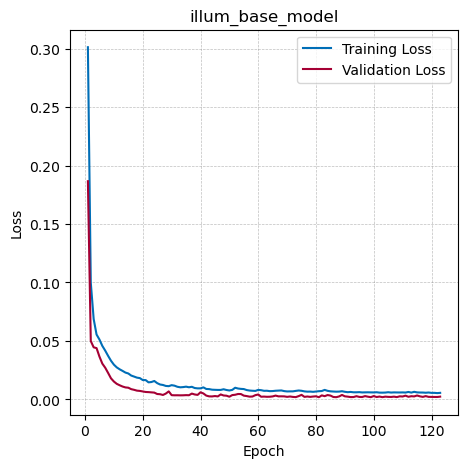

In [12]:
base_train_window_df, base_train_x, base_train_y = window_data_base_illumination(train_norm_df, 96)
base_test_window_df, base_test_x, base_test_y = window_data_base_illumination(test_norm_df, 96)

base_model = Model(base_train_x, base_train_y, base_test_x, base_test_y, "illum_base_model")
base_model.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=1,
)
base_model.train_model(500, base_early_stopping)

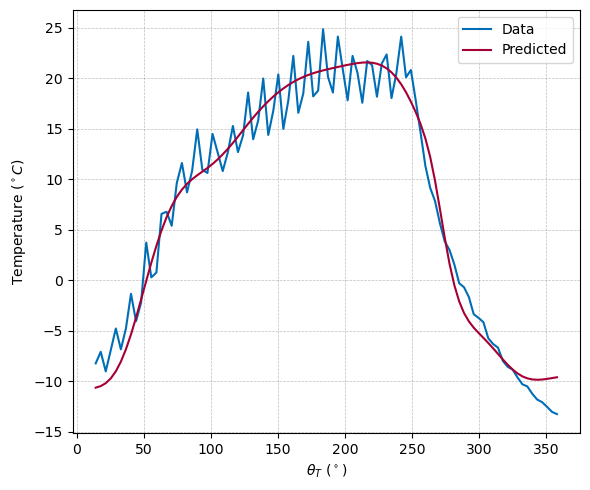

In [13]:

theta_T = base_test_window_df["theta_T"].to_numpy()
actual = denormalize_temperature(base_test_y, norm_limits)
predicted = denormalize_temperature(base_model.model.predict(base_test_x, verbose=0).flatten(), norm_limits)
base_errors = actual - predicted
try:
    start_index = base_test_window_df[base_test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][94]].index[0]
except:
    start_index = 0
end_index = base_test_window_df[base_test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][190]].index[0]

fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.plot(theta_T[start_index:end_index], actual[start_index:end_index], color=plt_colors[0], label="Data")
ax.plot(theta_T[start_index:end_index], predicted[start_index:end_index], color=plt_colors[1], label="Predicted")
ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
ax.set_ylabel(r"Temperature ($^\circ C$)")
ax.legend()
ax.grid()

plt.show()

## Residual models

In [14]:
def window_data_res_illumination(df, base_window_size, base_model, res_window_size, check_continuous=True):
    df = df.copy()
    columns = np.concatenate(
        (
            ["theta_T"],
            ["black panel in " + str(i) for i in range(res_window_size)],
            ["black panel pred"],
            ["black panel out"],
        )
    )

    window_df = pd.DataFrame(columns=columns, dtype=np.float64)
    illum_list = []

    with alive_bar(df.shape[0] - base_window_size, theme="classic", force_tty=True) as bar:
        for i in range(df.shape[0] - base_window_size):
            if check_continuous and (
                df.loc[i + base_window_size, "time (jd)"] - df.loc[i, "time (jd)"] > 1.25 * (i * 24 * 60)
            ):
                bar()
                continue

            window_df.loc[i, "theta_T"] = df.loc[i + base_window_size, "theta_T (deg)"]
            illumination = df.loc[i : i + base_window_size - 1, "illumination"].to_numpy()
            illum_list.append(illumination)
            # pred = base_model.predict(illumination.reshape(1, base_window_size, 1), verbose=0).flatten()[0]
            window_df.loc[i, "black panel in 0":f"black panel in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "black panel temperature (deg C)"
            ].to_numpy()
            
            # window_df.loc[i, "black panel pred"] = pred
            # window_df.loc[i, "black panel out"] = df.loc[i + base_window_size, "black panel temperature (deg C)"] - pred
            bar()
            
    preds = base_model.predict(np.array(illum_list).reshape(-1, base_window_size, 1), verbose=0).flatten()
    window_df["black panel pred"] = preds
    
    for i, row in window_df.iterrows():
        window_df.loc[i, "black panel out"] = df.loc[i + base_window_size, "black panel temperature (deg C)"] - row["black panel pred"]

    x = np.zeros((window_df.shape[0], res_window_size+1), dtype=np.float64)
    y = np.zeros((window_df.shape[0], 1), dtype=np.float64)

    x = window_df.iloc[:, -res_window_size-2:-1]
    y = window_df.iloc[:, -1].to_numpy()

    return window_df, x, y

In [11]:
res_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
res_model_layers[0] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[1] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[2] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[3] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[4] = {
    "type": "Dense",
    "units": 64,
    "activation": "relu",
}
res_model_layers[5] = {
    "type": "Dense",
    "units": 32,
    "activation": "relu",
}
res_model_layers[6] = {
    "type": "Dense",
    "units": 16,
    "activation": "relu",
}

res_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True,
    min_delta=1e-6,
)   # early stopping callback

[========================================] 838/838 [100%] in 1.1s (740.26/s)                                            
[========================================] 138/138 [100%] in 0.2s (777.90/s) 
Epoch 1/3500
9/9 [==============================] - 5s 52ms/step - loss: 0.0068 - mean_absolute_error: 0.0551 - val_loss: 0.0021 - val_mean_absolute_error: 0.0377
Epoch 2/3500
9/9 [==============================] - 0s 13ms/step - loss: 0.0065 - mean_absolute_error: 0.0542 - val_loss: 0.0021 - val_mean_absolute_error: 0.0375
Epoch 3/3500
9/9 [==============================] - 0s 12ms/step - loss: 0.0063 - mean_absolute_error: 0.0535 - val_loss: 0.0023 - val_mean_absolute_error: 0.0385
Epoch 4/3500
9/9 [==============================] - 0s 13ms/step - loss: 0.0061 - mean_absolute_error: 0.0529 - val_loss: 0.0021 - val_mean_absolute_error: 0.0376
Epoch 5/3500
9/9 [==============================] - 0s 12ms/step - loss: 0.0059 - mean_absolute_error: 0.0522 - val_loss: 0.0023 - val_mean_absolute_

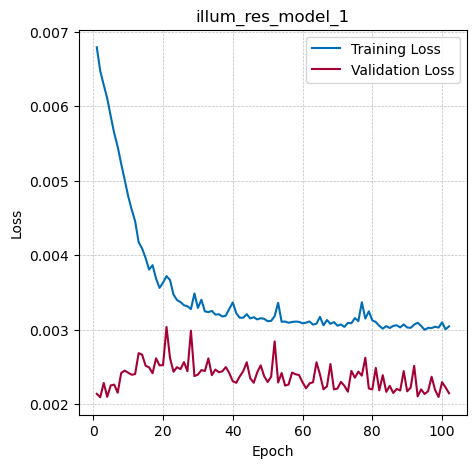

[========================================] 838/838 [100%] in 1.2s (744.27/s)                                            
[========================================] 138/138 [100%] in 0.3s (706.61/s)                                            
Epoch 1/3500
9/9 [==============================] - 4s 43ms/step - loss: 0.0071 - mean_absolute_error: 0.0563 - val_loss: 0.0022 - val_mean_absolute_error: 0.0381
Epoch 2/3500
9/9 [==============================] - 0s 12ms/step - loss: 0.0065 - mean_absolute_error: 0.0546 - val_loss: 0.0022 - val_mean_absolute_error: 0.0384
Epoch 3/3500
9/9 [==============================] - 0s 12ms/step - loss: 0.0063 - mean_absolute_error: 0.0538 - val_loss: 0.0021 - val_mean_absolute_error: 0.0379
Epoch 4/3500
9/9 [==============================] - 0s 11ms/step - loss: 0.0061 - mean_absolute_error: 0.0531 - val_loss: 0.0022 - val_mean_absolute_error: 0.0380
Epoch 5/3500
9/9 [==============================] - 0s 13ms/step - loss: 0.0059 - mean_absolute_error: 0.0

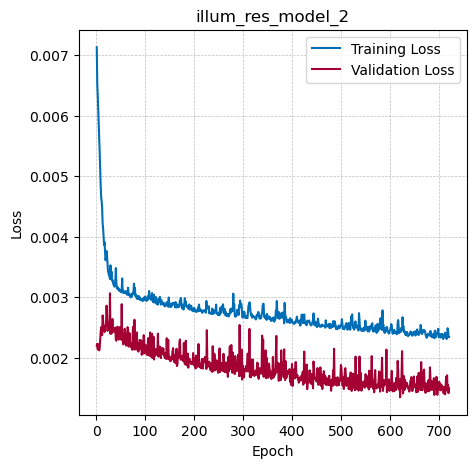

[========================================] 838/838 [100%] in 1.0s (843.86/s)                                            
[========================================] 138/138 [100%] in 0.2s (569.20/s)                                            
Epoch 1/3500
9/9 [==============================] - 4s 40ms/step - loss: 0.0068 - mean_absolute_error: 0.0552 - val_loss: 0.0021 - val_mean_absolute_error: 0.0374
Epoch 2/3500
9/9 [==============================] - 0s 14ms/step - loss: 0.0064 - mean_absolute_error: 0.0544 - val_loss: 0.0021 - val_mean_absolute_error: 0.0376
Epoch 3/3500
9/9 [==============================] - 0s 11ms/step - loss: 0.0062 - mean_absolute_error: 0.0533 - val_loss: 0.0025 - val_mean_absolute_error: 0.0401
Epoch 4/3500
9/9 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_absolute_error: 0.0525 - val_loss: 0.0021 - val_mean_absolute_error: 0.0379
Epoch 5/3500
9/9 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0

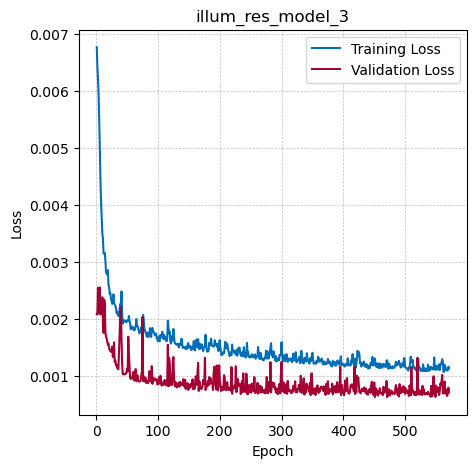

[========================================] 838/838 [100%] in 1.1s (803.94/s)                                            
[========================================] 138/138 [100%] in 0.2s (843.48/s)                                            
Epoch 1/3500
9/9 [==============================] - 4s 23ms/step - loss: 0.0071 - mean_absolute_error: 0.0563 - val_loss: 0.0023 - val_mean_absolute_error: 0.0387
Epoch 2/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_absolute_error: 0.0548 - val_loss: 0.0021 - val_mean_absolute_error: 0.0375
Epoch 3/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_absolute_error: 0.0541 - val_loss: 0.0021 - val_mean_absolute_error: 0.0375
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0063 - mean_absolute_error: 0.0534 - val_loss: 0.0021 - val_mean_absolute_error: 0.0373
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_error: 0.0524 

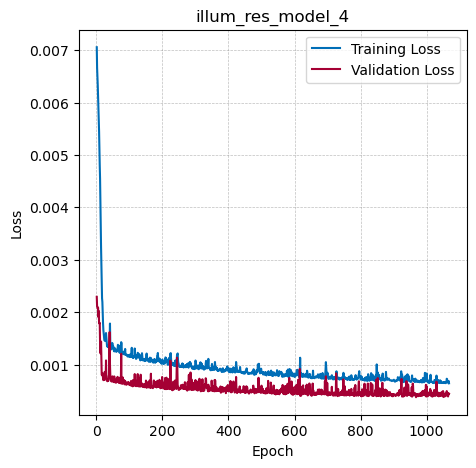

[========================================] 838/838 [100%] in 0.6s (1451.39/s)                                           
[========================================] 138/138 [100%] in 0.1s (1625.18/s)                                           
Epoch 1/3500
9/9 [==============================] - 2s 24ms/step - loss: 0.0074 - mean_absolute_error: 0.0578 - val_loss: 0.0026 - val_mean_absolute_error: 0.0408
Epoch 2/3500
9/9 [==============================] - 0s 11ms/step - loss: 0.0066 - mean_absolute_error: 0.0546 - val_loss: 0.0020 - val_mean_absolute_error: 0.0373
Epoch 3/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_absolute_error: 0.0539 - val_loss: 0.0023 - val_mean_absolute_error: 0.0385
Epoch 4/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0531 - val_loss: 0.0019 - val_mean_absolute_error: 0.0365
Epoch 5/3500
9/9 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0514

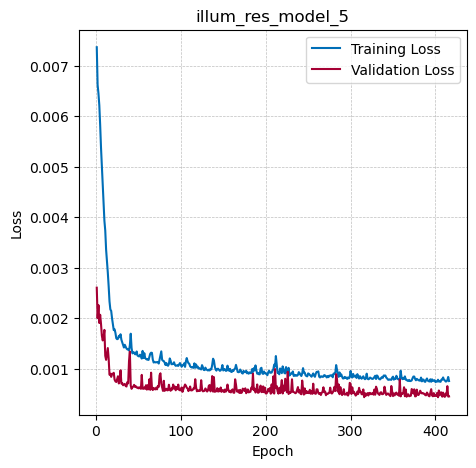

[========================================] 838/838 [100%] in 0.7s (1289.43/s)                                           
[========================================] 138/138 [100%] in 0.1s (1569.62/s)                                           
Epoch 1/3500
9/9 [==============================] - 2s 24ms/step - loss: 0.0067 - mean_absolute_error: 0.0550 - val_loss: 0.0023 - val_mean_absolute_error: 0.0387
Epoch 2/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0533 - val_loss: 0.0019 - val_mean_absolute_error: 0.0360
Epoch 3/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0515 - val_loss: 0.0020 - val_mean_absolute_error: 0.0366
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0499 - val_loss: 0.0019 - val_mean_absolute_error: 0.0352
Epoch 5/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0476 

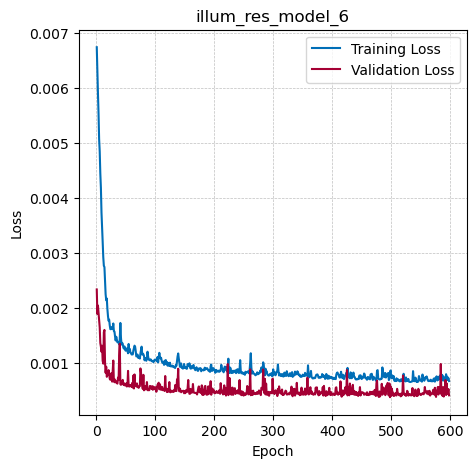

[========================================] 838/838 [100%] in 0.6s (1321.77/s)                                           
[========================================] 138/138 [100%] in 0.1s (1598.97/s)                                           
Epoch 1/3500
9/9 [==============================] - 2s 24ms/step - loss: 0.0072 - mean_absolute_error: 0.0568 - val_loss: 0.0022 - val_mean_absolute_error: 0.0380
Epoch 2/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_absolute_error: 0.0537 - val_loss: 0.0019 - val_mean_absolute_error: 0.0361
Epoch 3/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0518 - val_loss: 0.0022 - val_mean_absolute_error: 0.0380
Epoch 4/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_absolute_error: 0.0503 - val_loss: 0.0017 - val_mean_absolute_error: 0.0343
Epoch 5/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0486 

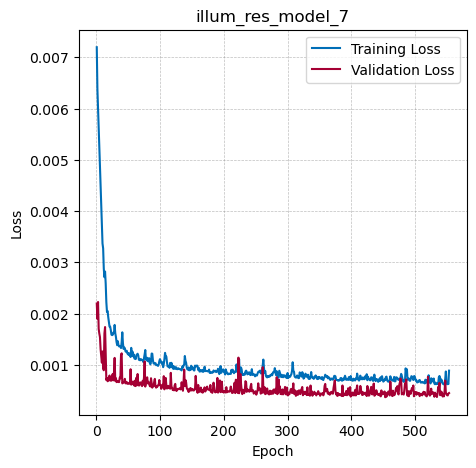

[========================================] 838/838 [100%] in 0.7s (1248.85/s)                                           
[========================================] 138/138 [100%] in 0.1s (1507.73/s)                                           
Epoch 1/3500
9/9 [==============================] - 2s 23ms/step - loss: 0.0066 - mean_absolute_error: 0.0546 - val_loss: 0.0020 - val_mean_absolute_error: 0.0360
Epoch 2/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_absolute_error: 0.0515 - val_loss: 0.0018 - val_mean_absolute_error: 0.0353
Epoch 3/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0501 - val_loss: 0.0019 - val_mean_absolute_error: 0.0352
Epoch 4/3500
9/9 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_absolute_error: 0.0481 - val_loss: 0.0018 - val_mean_absolute_error: 0.0338
Epoch 5/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0460 

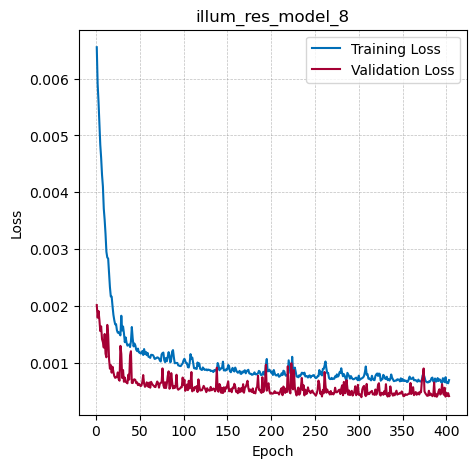

[========================================] 838/838 [100%] in 0.8s (1106.25/s)                                           
[========================================] 138/138 [100%] in 0.3s (750.31/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 22ms/step - loss: 0.0067 - mean_absolute_error: 0.0554 - val_loss: 0.0021 - val_mean_absolute_error: 0.0370
Epoch 2/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_error: 0.0523 - val_loss: 0.0017 - val_mean_absolute_error: 0.0348
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_error: 0.0499 - val_loss: 0.0020 - val_mean_absolute_error: 0.0357
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0469 - val_loss: 0.0018 - val_mean_absolute_error: 0.0336
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0445 

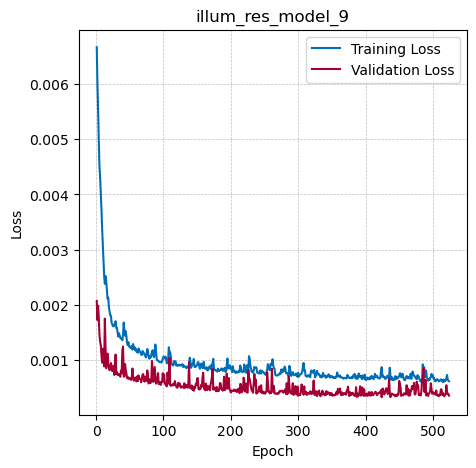

[========================================] 838/838 [100%] in 0.6s (1478.59/s)                                           
[========================================] 138/138 [100%] in 0.1s (1493.22/s)                                           
Epoch 1/3500
9/9 [==============================] - 2s 24ms/step - loss: 0.0071 - mean_absolute_error: 0.0567 - val_loss: 0.0022 - val_mean_absolute_error: 0.0378
Epoch 2/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_absolute_error: 0.0543 - val_loss: 0.0022 - val_mean_absolute_error: 0.0386
Epoch 3/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_absolute_error: 0.0535 - val_loss: 0.0022 - val_mean_absolute_error: 0.0387
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0528 - val_loss: 0.0020 - val_mean_absolute_error: 0.0367
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0507 

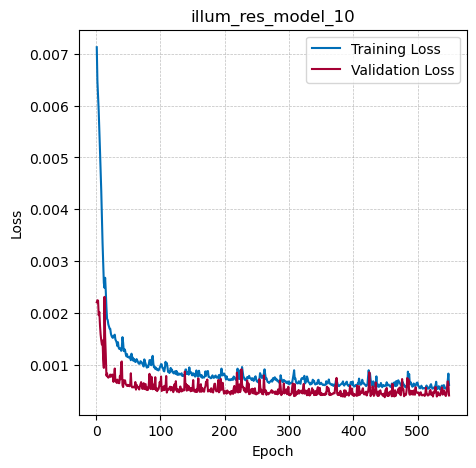

In [16]:
res_window_sizes = np.arange(1, 11, 1)
res_models = []

for res_window_size in res_window_sizes:
    res_train_window_df, res_train_x, res_train_y = window_data_res_illumination(train_norm_df, 96, base_model.model, res_window_size)
    res_test_window_df, res_test_x, res_test_y = window_data_res_illumination(test_norm_df, 96, base_model.model, res_window_size)
    
    res_model = Model(res_train_x, res_train_y, res_test_x, res_test_y, f"illum_res_model_{res_window_size}")
    
    res_model.create_model(
        res_model_layers,
        tf.keras.optimizers.Adam(learning_rate=1e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(res_window_size+1,),
        output_shape=1,
    )
    
    res_model.train_model(3500, res_early_stopping)
    res_models.append(res_model.model)
            

In [19]:
plt.rcParams.update({'font.size': 16})

[==>                                     ] - 9/138 [7%] in 0s (~0s, 1233.3/s) 

[========================================] 138/138 [100%] in 0.2s (979.88/s)                                            
[========================================] 138/138 [100%] in 0.2s (771.81/s)                                            
Window Size: 1


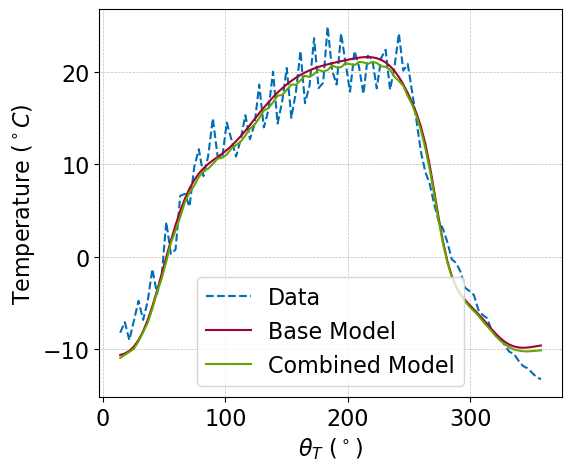

[========================================] 138/138 [100%] in 0.2s (759.27/s)                                            
[========================================] 138/138 [100%] in 0.2s (1195.89/s)                                           
Window Size: 2


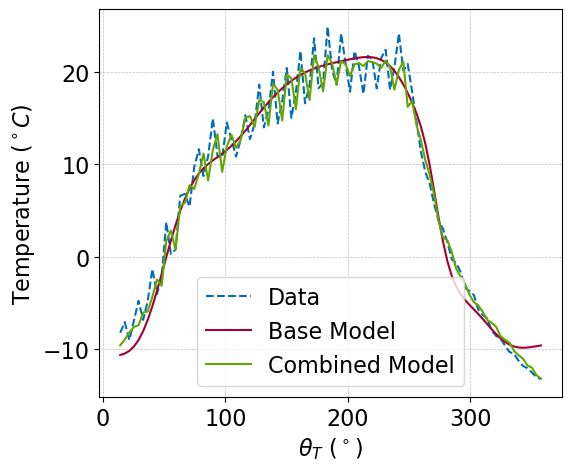

[========================================] 138/138 [100%] in 0.1s (1343.12/s)                                           
[========================================] 138/138 [100%] in 0.2s (723.10/s)                                            
Window Size: 3


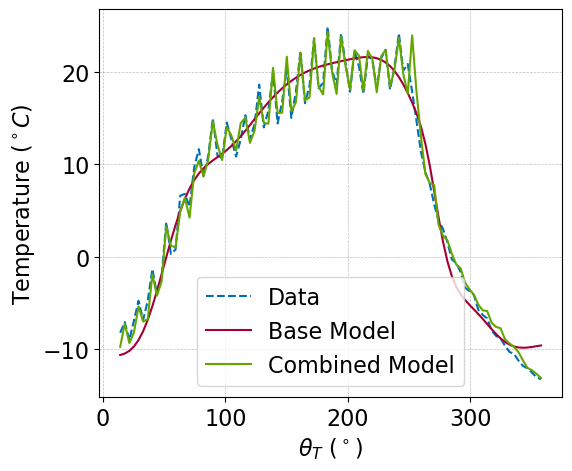

[========================================] 138/138 [100%] in 0.2s (831.93/s)                                            
[========================================] 138/138 [100%] in 0.1s (1434.85/s)                                           
Window Size: 4


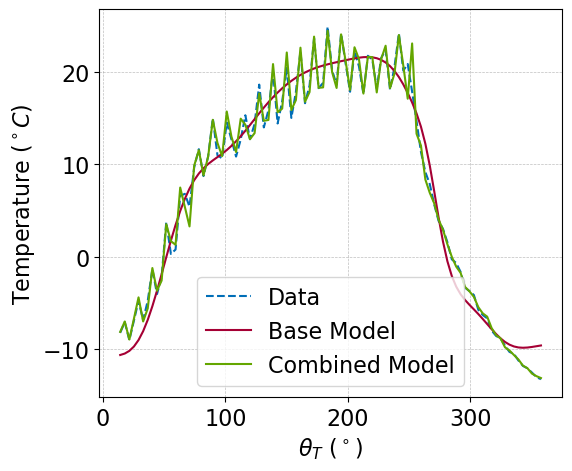

[========================================] 138/138 [100%] in 0.2s (798.01/s)                                            
[========================================] 138/138 [100%] in 0.2s (962.22/s)                                            
Window Size: 5


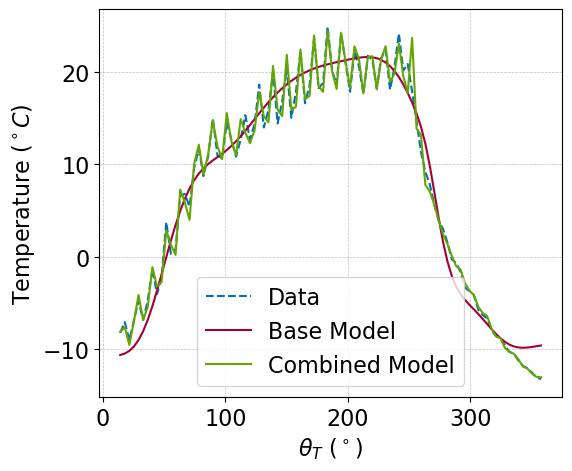

[========================================] 138/138 [100%] in 0.2s (866.06/s)                                            
[========================================] 138/138 [100%] in 0.1s (1407.04/s)                                           
Window Size: 6


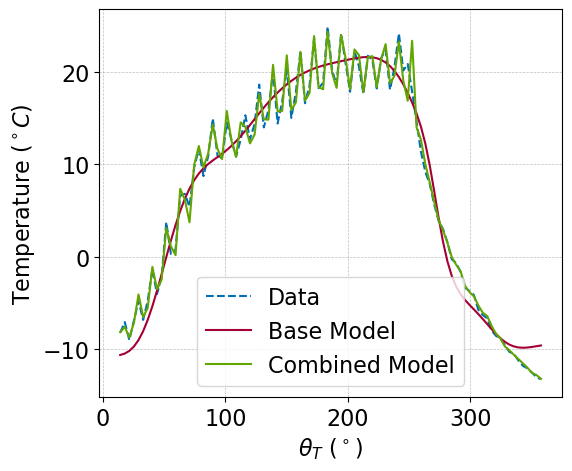

[========================================] 138/138 [100%] in 0.2s (850.24/s)                                            
[========================================] 138/138 [100%] in 0.1s (1158.38/s)                                           
Window Size: 7


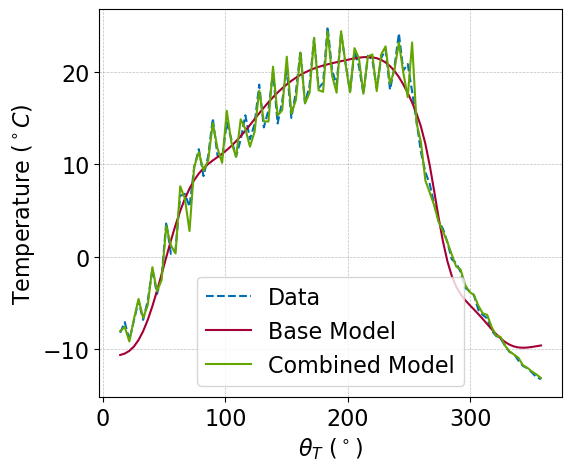

[========================================] 138/138 [100%] in 0.1s (1158.18/s)                                           
[========================================] 138/138 [100%] in 0.1s (1050.92/s)                                           
Window Size: 8


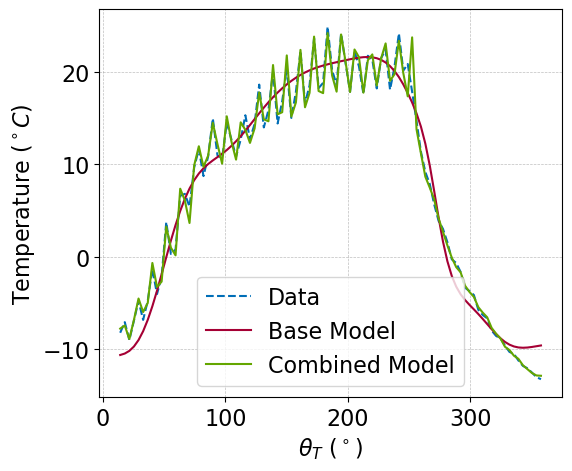

[========================================] 138/138 [100%] in 0.2s (802.02/s)                                            
[========================================] 138/138 [100%] in 0.2s (834.19/s)                                            
Window Size: 9


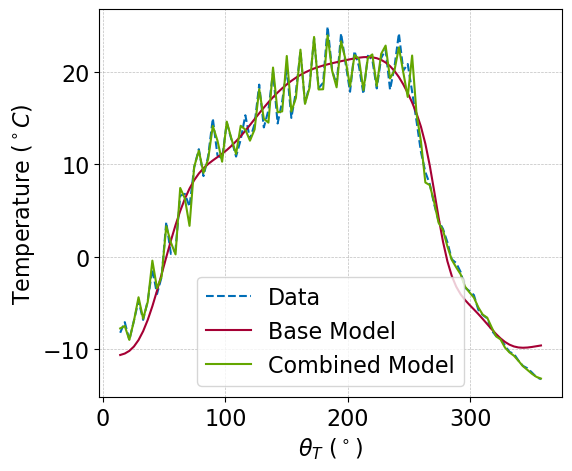

[========================================] 138/138 [100%] in 0.1s (1104.27/s)                                           
[========================================] 138/138 [100%] in 0.1s (1485.36/s)                                           
Window Size: 10


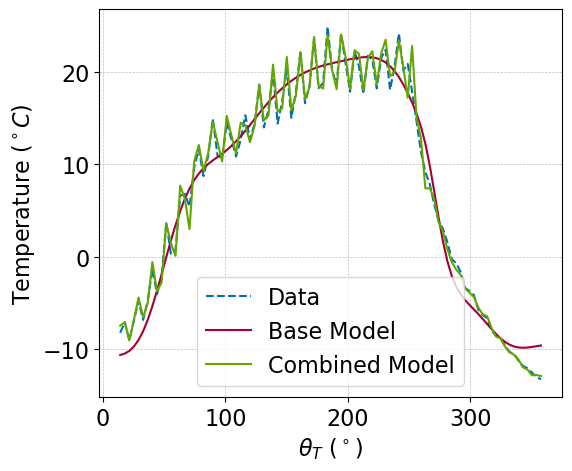

In [21]:
errors = []
idxs = [1, 3, 7]
for idx, res_window_size in enumerate(res_window_sizes):
    res_model = res_models[idx]

    test_window_df, test_x, test_y = window_data_base_illumination(test_norm_df, 96)
    test_window_res_df, test_res_x, test_res_y = window_data_res_illumination(test_norm_df, 96, base_model.model, res_window_size)

    theta_T = test_window_df.iloc[:, 0].to_numpy()
    actual = denormalize_temperature(test_y, norm_limits)
    base_preds = base_model.model.predict(test_x, verbose=0).flatten()
    res_preds = res_model.predict(test_res_x, verbose=0).flatten()
    combined_preds = denormalize_temperature(base_preds + res_preds, norm_limits)
    base_preds = denormalize_temperature(base_preds, norm_limits)
    
    res_errors = (actual - combined_preds)

    errors.append(res_errors)
    
    try:
        start_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][94]].index[0]
    except:
        start_index = 0
            
    end_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][190]].index[0]

    print(f"Window Size: {res_window_size}")
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index], color=plt_colors[0], label="Data", linestyle="--")
    ax.plot(theta_T[start_index:end_index], base_preds[start_index:end_index], color=plt_colors[1], label="Base Model")
    ax.plot(theta_T[start_index:end_index], combined_preds[start_index:end_index], color=plt_colors[2], label="Combined Model")
    ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    ax.grid()
    ax.legend()
    plt.show()
    
    if idx in idxs:
        fig.savefig(f"../../report/images/chapter-4/funcube-black-panel-illumination-combined-{res_window_size}.pdf")

In [22]:
stat_errors = np.array(errors)
stat_errors = np.concatenate([base_errors.reshape(1, -1), stat_errors], axis=0).T
steps = np.arange(0, 11)
mu = np.mean(stat_errors, axis=0)
sigma = np.std(stat_errors, axis=0)

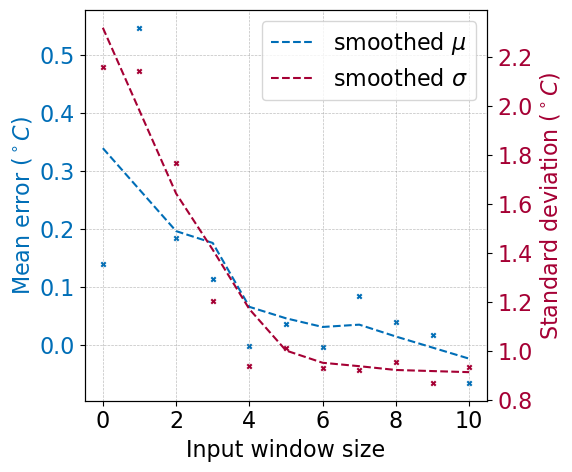

In [23]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(steps, mu, s=10, color=plt_colors[0], marker="x")
# smoothed line
ax.plot(steps, savgol_filter(mu, 5, 1), color=plt_colors[0], linestyle="--", label="smoothed $\mu$")
twin_ax = ax.twinx()
twin_ax.scatter(steps, sigma, s=10, color=plt_colors[1], marker="x")
# smoothed line
twin_ax.plot(steps, savgol_filter(sigma, 5, 1), color=plt_colors[1], linestyle="--", label="smoothed $\sigma$")

# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax.set_ylabel(r"Mean error ($^\circ C$)", color=plt_colors[0])
twin_ax.set_ylabel(r"Standard deviation ($^\circ C$)", color=plt_colors[1])
ax.tick_params(axis="y", labelcolor=plt_colors[0])
twin_ax.tick_params(axis="y", labelcolor=plt_colors[1])
ax.set_xlabel("Input window size")
ax.grid()

plt.show()

fig.savefig("../../report/images/chapter-4/funcube-black-panel-illumination-combined-error.pdf")

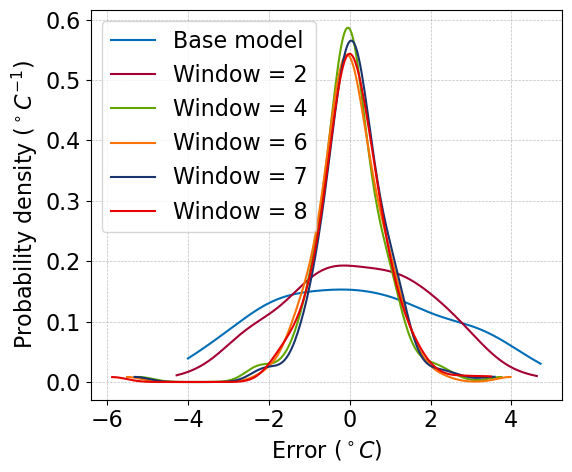

In [24]:
idxs = [0, 2, 4, 6, 7, 8]
kde_vals, bins = kde(stat_errors[:, idxs], plot_kde=False)
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
for i in range(len(idxs)):
    ax.plot(bins[i], kde_vals[i], color=plt_colors[i])
    
ax.set_xlabel(r"Error ($^\circ C$)")
ax.set_ylabel(r"Probability density ($^\circ C^{-1}$)")
ax.legend(["Base model"] + [f"Window = {idx}" for idx in idxs[1:]])
ax.grid()
plt.show()

fig.savefig("../../report/images/chapter-4/funcube-black-panel-illumination-combined-error-kde.pdf")

[========================================] 129/129 [100%] in 0.1s (1291.51/s)                                           
[========================================] 129/129 [100%] in 0.1s (1425.45/s)                                           
Window Size: 2


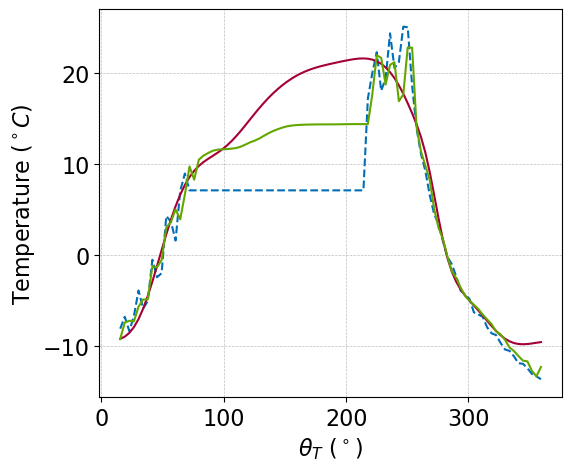

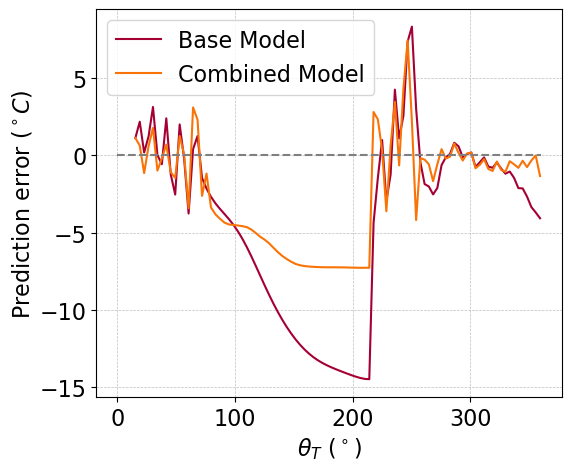

[========================================] 129/129 [100%] in 0.2s (1111.36/s)                                           
[========================================] 129/129 [100%] in 0.1s (1150.63/s)                                           
Window Size: 4


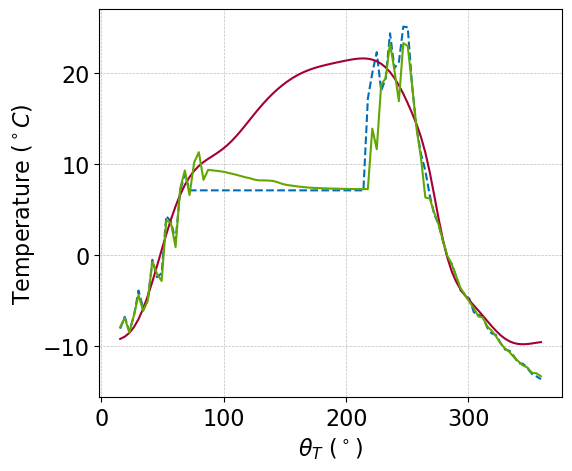

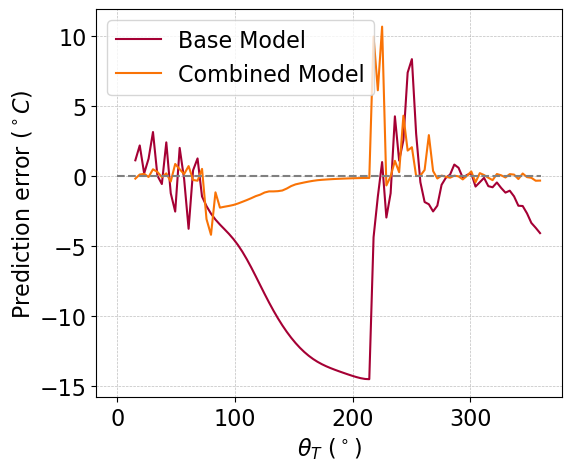

[========================================] 129/129 [100%] in 0.1s (1211.33/s)                                           
[========================================] 129/129 [100%] in 0.2s (921.60/s)                                            
Window Size: 8


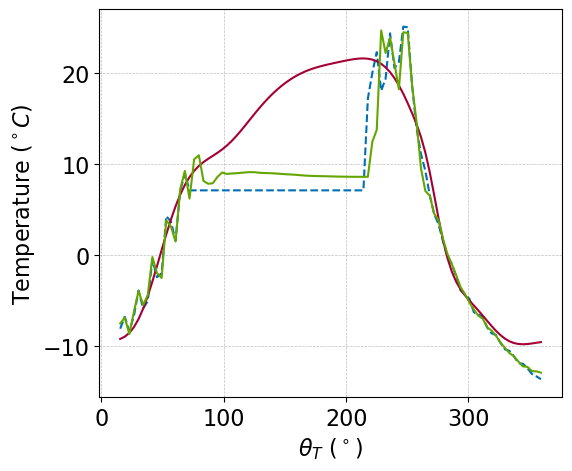

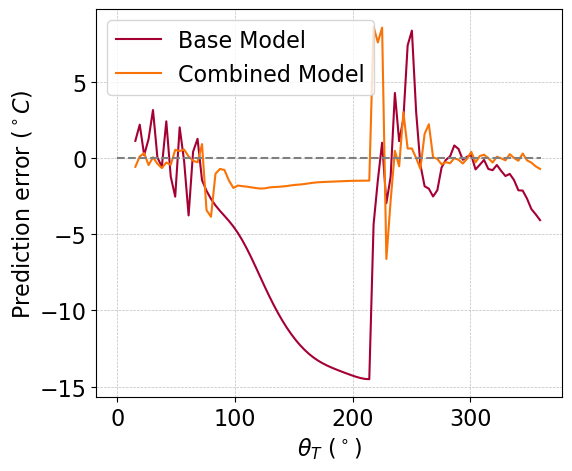

In [25]:
idxs = [1, 3, 7]
for idx in idxs:
    res_model = res_models[idx]
    res_window_size = res_window_sizes[idx]
    anomaly_base_window_df, anomaly_base_test_x, anomaly_base_test_y = window_data_base_illumination(anomaly_norm_df, 96)
    anomaly_res_window_df, anomaly_res_test_x, anomaly_res_test_y = window_data_res_illumination(anomaly_norm_df, 96, base_model.model, res_window_size)
    theta_T = anomaly_base_window_df["theta_T"].to_numpy()
    actual = denormalize_temperature(anomaly_base_test_y, norm_limits)
    base_preds = base_model.model.predict(anomaly_base_test_x, verbose=0).flatten()
    res_preds = res_model.predict(anomaly_res_test_x, verbose=0).flatten()
    combined_preds = denormalize_temperature(base_preds + res_preds, norm_limits)
    base_preds = denormalize_temperature(base_preds, norm_limits)
    
    base_preds_error = actual - base_preds
    res_preds_error = actual - combined_preds

    try:
        start_index = anomaly_base_window_df[anomaly_base_window_df["theta_T"] == anomaly_df["theta_T (deg)"][127]].index[0]
    except:
        start_index = 0
    end_index = anomaly_base_window_df[anomaly_base_window_df["theta_T"] == anomaly_df["theta_T (deg)"][221]].index[0]
    print(f"Window Size: {res_window_size}")
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index], color=plt_colors[0], label="Data", linestyle="--")
    ax.plot(theta_T[start_index:end_index], base_preds[start_index:end_index], color=plt_colors[1], label="Base Model")
    ax.plot(theta_T[start_index:end_index], combined_preds[start_index:end_index], color=plt_colors[2], label="Combined Model")
    ax.grid()
    ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    plt.show()
    
    fig.savefig(f"../../report/images/chapter-4/funcube-black-panel-illumination-anomaly-combined-preds-{res_window_size}.pdf")
    
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], base_preds_error[start_index:end_index], color=plt_colors[1], label="Base Model")
    ax.plot(theta_T[start_index:end_index], res_preds_error[start_index:end_index], color=plt_colors[3], label="Combined Model")
    ax.hlines(0, 0, 360, color="grey", linestyle="--")
    ax.grid()
    ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    ax.set_ylabel(r"Prediction error ($^\circ C$)")
    ax.legend()
    plt.show()
    
    fig.savefig(f"../../report/images/chapter-4/funcube-black-panel-illumination-anomaly-combined-preds-error-{res_window_size}.pdf")

## Base model : all channels

In [12]:
def window_data_base_illumination_all_channels(df, window_size, check_continuous=True):
    df = df.copy()
    columns = np.concatenate(
        (
            ["theta_T"],
            ["illumination " + str(i) for i in range(window_size)],
            ["black chassis out"],
            ["silver chassis out"],
            ["black panel out"],
            ["silver panel out"],
            ["solar panel +X out"],
            ["solar panel -X out"],
            ["solar panel +Y out"],
            ["solar panel -Y out"],
        )
    )

    window_df = pd.DataFrame(columns=columns, dtype=np.float64)

    with alive_bar(df.shape[0] - window_size, theme="classic", force_tty=True) as bar:
        for i in range(df.shape[0] - window_size):
            if check_continuous and (
                df.loc[i + window_size, "time (jd)"] - df.loc[i, "time (jd)"] > 1.25 * (i * 24 * 60)
            ):
                bar()
                continue

            window_df.loc[i, "theta_T"] = df.loc[i + window_size, "theta_T (deg)"]
            window_df.loc[i, "illumination 0" : "illumination " + str(window_size - 1)] = df.loc[
                i : i + window_size - 1, "illumination"
            ].to_numpy()
            window_df.loc[i, "black chassis out":"solar panel -Y out"] = df.loc[
                i + window_size, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"
            ].to_numpy()
            bar()

    x = np.zeros((window_df.shape[0], window_size), dtype=np.float64)
    y = np.zeros((window_df.shape[0], 8), dtype=np.float64)

    x = window_df.iloc[:, 1:-8].to_numpy()
    y = window_df.iloc[:, -8:].to_numpy()

    return window_df, x.reshape(-1, window_size, 1), y

[========================================] 838/838 [100%] in 2.8s (306.57/s)                                            
[========================================] 138/138 [100%] in 0.5s (321.40/s)                                            


2023-06-26 15:14:39.433539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:14:39.434415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 15:14:39.434892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 15:14:39.435250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Epoch 1/500


2023-06-26 15:14:56.011591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-26 15:14:56.392756: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1cb43370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-26 15:14:56.392799: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-06-26 15:14:56.401107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-26 15:14:56.525889: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-26 15:14:56.592550: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 18s 490ms/step - loss: 0.3211 - mean_absolute_error: 0.5094 - val_loss: 0.2518 - val_mean_absolute_error: 0.4480
Epoch 2/500
9/9 [==============================] - 1s 75ms/step - loss: 0.2063 - mean_absolute_error: 0.3853 - val_loss: 0.1520 - val_mean_absolute_error: 0.3185
Epoch 3/500
9/9 [==============================] - 1s 72ms/step - loss: 0.1365 - mean_absolute_error: 0.3014 - val_loss: 0.1028 - val_mean_absolute_error: 0.2660
Epoch 4/500
9/9 [==============================] - 1s 74ms/step - loss: 0.1003 - mean_absolute_error: 0.2638 - val_loss: 0.0788 - val_mean_absolute_error: 0.2342
Epoch 5/500
9/9 [==============================] - 1s 72ms/step - loss: 0.0829 - mean_absolute_error: 0.2450 - val_loss: 0.0677 - val_mean_absolute_error: 0.2203
Epoch 6/500
9/9 [==============================] - 1s 73ms/step - loss: 0.0740 - mean_absolute_error: 0.2350 - val_loss: 0.0609 - val_mean_absolute_error: 0.2116
Epoch 7/500
9/9 [=====================

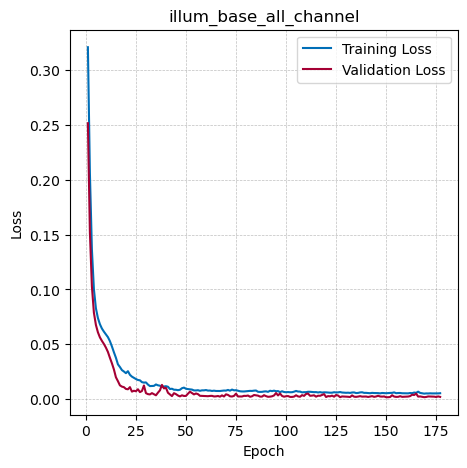

In [13]:
(
    base_all_channel_train_window_df,
    base_all_channel_train_x,
    base_all_channel_train_y,
) = window_data_base_illumination_all_channels(train_norm_df, 96)

(
    base_all_channel_test_window_df,
    base_all_channel_test_x,
    base_all_channel_test_y,
) = window_data_base_illumination_all_channels(test_norm_df, 96)

base_model_all_channel = Model(
    base_all_channel_train_x,
    base_all_channel_train_y,
    base_all_channel_test_x,
    base_all_channel_test_y,
    "illum_base_all_channel",
)

base_model_all_channel.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=8,
)

base_model_all_channel.train_model(500, base_early_stopping)

In [14]:
theta_T = base_all_channel_test_window_df["theta_T"].to_numpy()
actual = denormalize_temperature(base_all_channel_test_y, norm_limits)
predicted = denormalize_temperature(base_model_all_channel.model.predict(base_all_channel_test_x), norm_limits)
base_errors = actual - predicted

try:
    start_index = base_all_channel_test_window_df[base_all_channel_test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][94]].index[0]
except:
    start_index = 0
end_index = base_all_channel_test_window_df[base_all_channel_test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][190]].index[0]

5/5 [==============================] - 3s 17ms/step


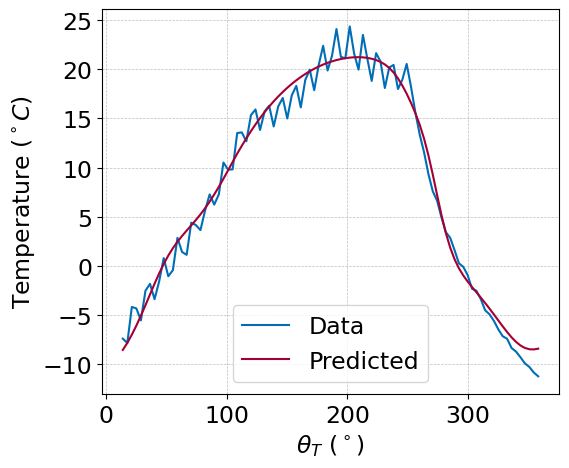

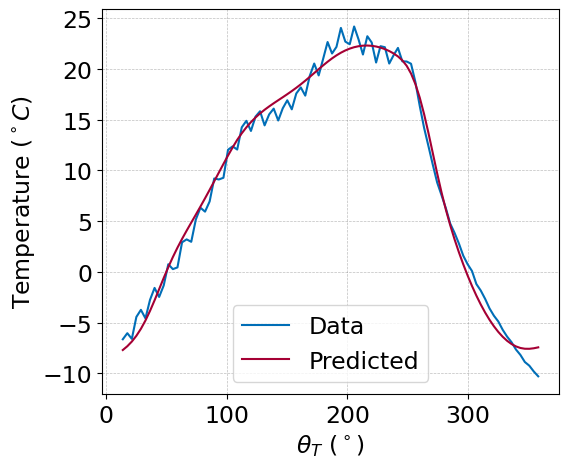

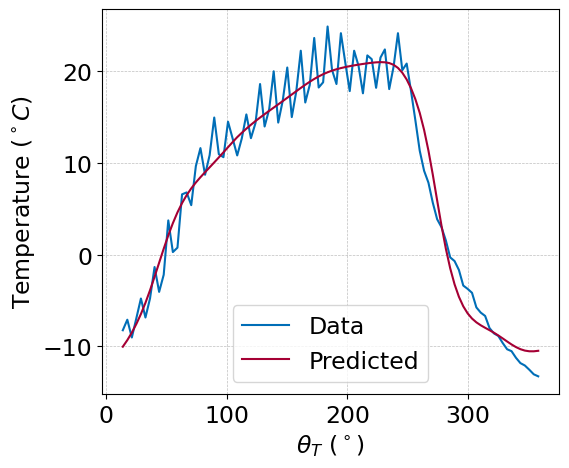

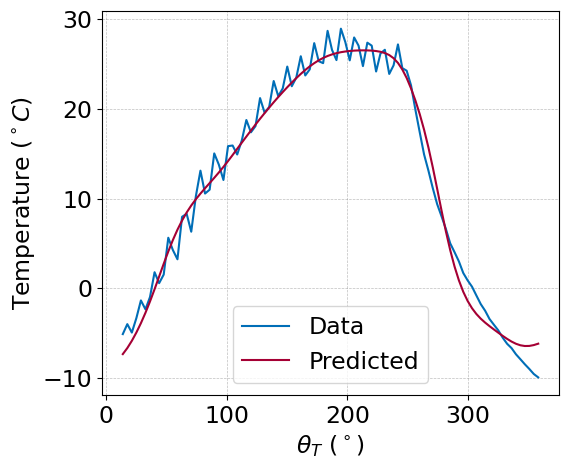

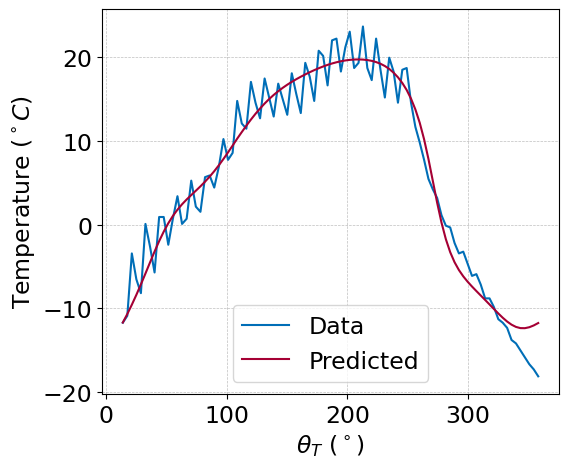

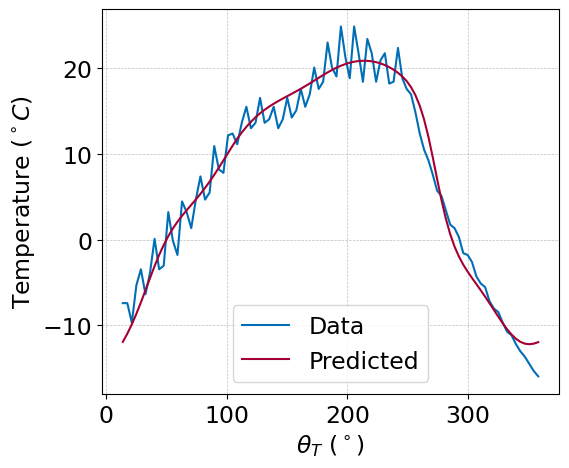

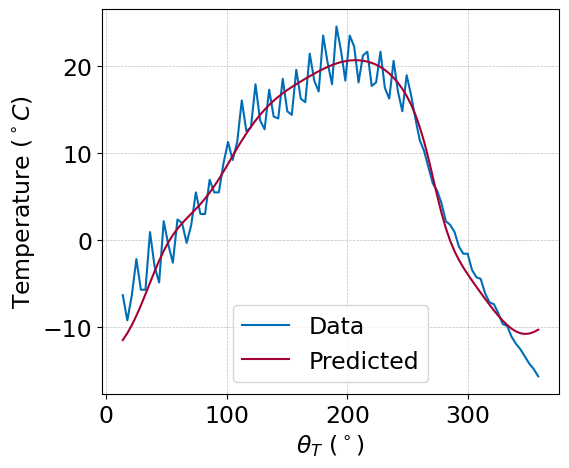

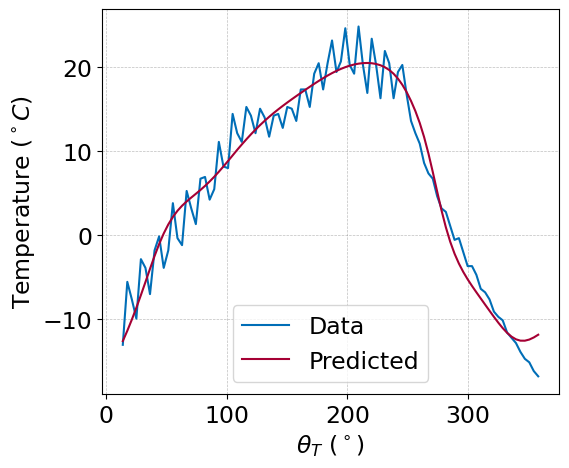

In [15]:
# fig, ax = plt.subplots(2, 4, figsize=(24, 10), tight_layout=True)
# for idx in range(8):
#     i, j = np.unravel_index(idx, (2, 4))
#     ax[i, j].plot(theta_T[start_index:end_index], actual[start_index:end_index, idx], color=plt_colors[0])
#     ax[i, j].plot(theta_T[start_index:end_index], predicted[start_index:end_index, idx], color=plt_colors[1])
#     ax[i, j].set_xlabel(r"$\theta_T$ ($^\circ$)")
#     ax[i, j].set_ylabel(r"Temperature ($^\circ C$)")
#     ax[i, j].grid()


# plt.show()
plt.rcParams.update({"font.size": 17})
titles = [
    "black-chassis",
    "silver-chassis",
    "black-panel",
    "silver-panel",
    "+X solar-panel",
    "-X solar-panel",
    "+Y solar-panel",
    "-Y solar-panel",
]

for idx in range(8):
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index, idx], color=plt_colors[0], label="Data")
    ax.plot(theta_T[start_index:end_index], predicted[start_index:end_index, idx], color=plt_colors[1], label="Predicted")
    ax.grid()
    ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    ax.legend()
    plt.show()
    
    # fig.savefig(f"../../report/images/chapter-4/funcube-all-channel-illumination-base-{titles[idx]}.pdf")

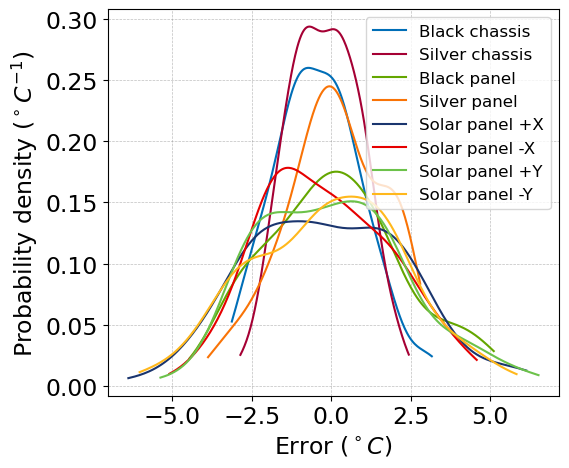

In [17]:
labels=[
        "Black chassis",
        "Silver chassis",
        "Black panel",
        "Silver panel",
        "Solar panel +X",
        "Solar panel -X",
        "Solar panel +Y",
        "Solar panel -Y",
    ]

kde_vals, bins = kde(
    base_errors,
    plot_kde=False,
)
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
for i in range(8):
    ax.plot(bins[i], kde_vals[i], label=labels[i],  color=plt_colors[i])
ax.set_xlabel(r"Error ($^\circ C$)")
ax.set_ylabel(r"Probability density ($^\circ C^{-1}$)")
ax.grid()
# fig.legend(["Data", "Base Model", "Combined Model"], loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.04), bbox_transform=fig.transFigure)
# ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.0))
ax.legend(fontsize=12)
fig.savefig("../../report/images/chapter-4/funcube-all-channel-illumination-base-error-kde.pdf")

In [18]:
print(f"mu = {np.mean(base_errors)}, sigma = {np.std(base_errors)}")

mu = -0.10507546021120392, sigma = 1.9844079668840986


# Curve fit models

In [10]:
from scipy.optimize import curve_fit

In [11]:
fe_mean = np.mean(telem_df["fe"])   # Mean fe for the data
theta_E = 360 * (1 - fe_mean)       # Mean theta_E for the data

def fit_function(theta_T, T_sat_rising, r_rising, T_0, dT_0_falling):
    """
    Function to fit to the temperature data.
    :param theta_T: Array of theta_T values
    :param T_sat_rising: Saturation temperature of the heating phase
    :param r_rising: Rate of temperature rise during heating phase
    :param T_0: Temperature at theta_T = 0
    :param dT_0_falling: delta T between T_0 and saturation temperature of cooling phase
    """
    T_E = T_sat_rising * (1 - np.exp(-r_rising * theta_E)) + T_0    # Temperature at the beginning of ecllipse

    T_sat_falling = T_0 - dT_0_falling  # Saturation cooling temperature at theta_T = inf

    # Determining rate of falling temperature to satisfy T_begin = T_end at theta_E = 0 and theta_E = 360
    r_falling = -np.log(dT_0_falling / (T_E - T_sat_falling)) / (360 - theta_E)

    return_array = np.empty(shape=theta_T.shape, dtype=np.float64)

    for i, theta_T_i in enumerate(theta_T):
        if theta_T_i < theta_E:
            return_array[i] = T_sat_rising * (1 - np.exp(-r_rising * theta_T_i)) + T_0
        else:
            return_array[i] = (T_E - T_sat_falling) * np.exp(-r_falling * (theta_T_i - theta_E)) + T_sat_falling

    return return_array

In [23]:
fit_params = np.zeros(shape=(8, 4), dtype=np.float64)
fit_errors = np.zeros(shape=(8, 4), dtype=np.float64)

for i in range(8):
    popt, pcov = curve_fit(
        fit_function,
        test_df["theta_T (deg)"].to_numpy(),
        test_df.iloc[:, -9+i].to_numpy() + 273.15,
        p0=[25, 0.01, 300, 10],
        bounds=([5, 0, 200, 0.1], [150, 1, 350, 75]),
    )
    
    fit_params[i] = popt
    fit_errors[i] = np.sqrt(np.diag(pcov))

In [20]:
titles = [
    "black-chassis",
    "silver-chassis",
    "black-panel",
    "silver-panel",
    "+X solar-panel",
    "-X solar-panel",
    "+Y solar-panel",
    "-Y solar-panel",
]


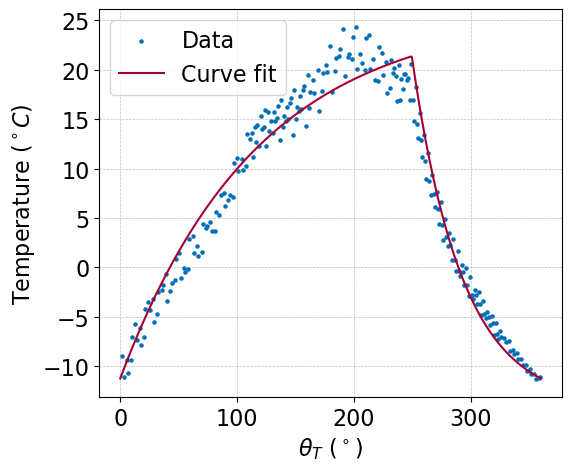

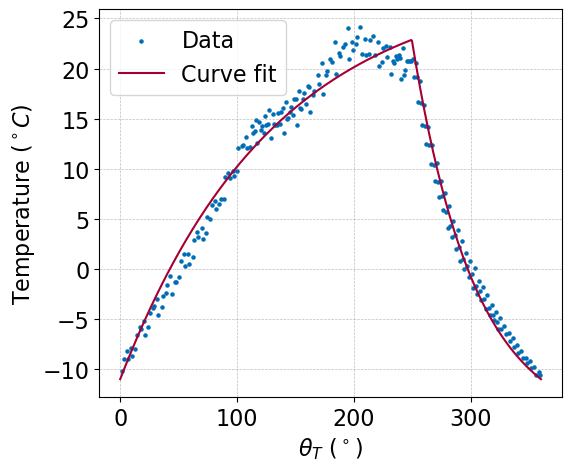

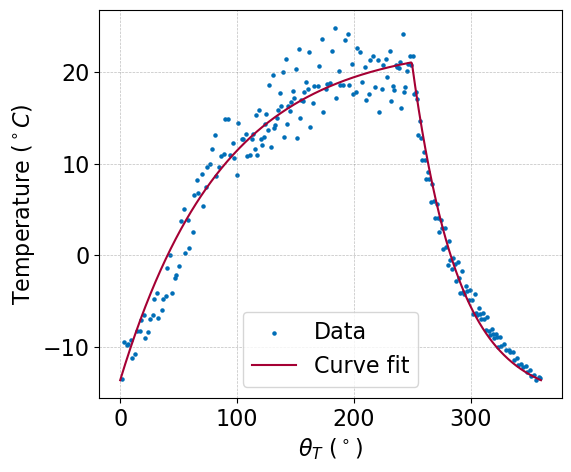

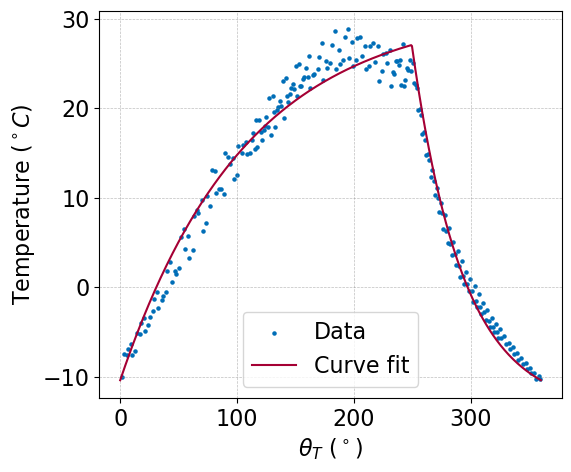

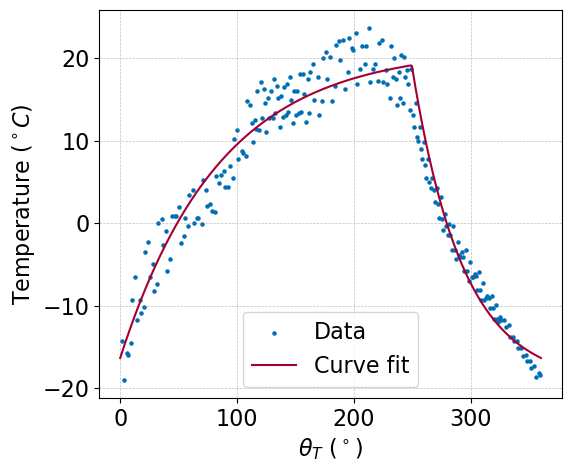

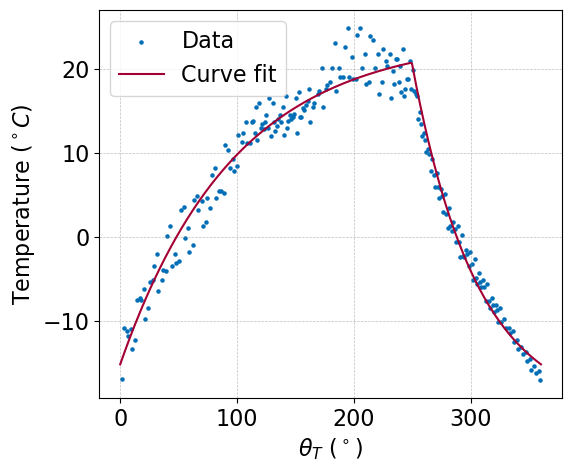

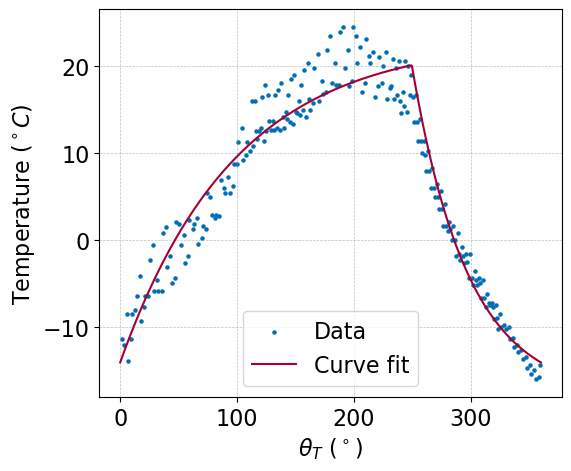

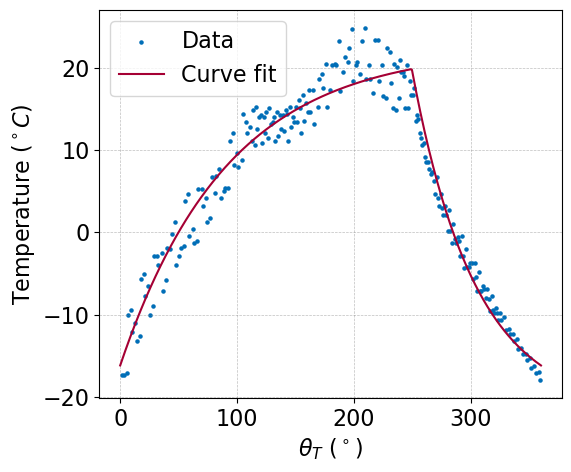

In [21]:
# Plotting the curve fit:
theta_T_fit = np.linspace(0, 360, 500)
temp_fit = np.empty(shape=(theta_T_fit.shape[0], 8), dtype=np.float64)

for i in range(8):
    temp_fit[:, i] = fit_function(theta_T_fit, *fit_params[i]) - 273.15

# _ = plot_model(
#     [test_df["theta_T (deg)"].to_numpy(), theta_T_fit],
#     [test_df.iloc[:, -9:-1].to_numpy(), temp_fit],
#     plt_titles=[
#         "Black chassis",
#         "Silver chassis",
#         "Black panel",
#         "Silver panel",
#         "Solar panel +X",
#         "Solar panel -X",
#         "Solar panel +Y",
#         "Solar panel -Y"
#     ],
#     labels=["Data", "Curve fit"],
#     plt_scatter=[True, False],
# )
plt.rcParams.update({'font.size': 16})
for i in range(8):
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.scatter(test_df["theta_T (deg)"], test_df.iloc[:, -9+i], color=plt_colors[0], label="Data", s=5)
    ax.plot(theta_T_fit, temp_fit[:, i], color=plt_colors[1], label="Curve fit")
    ax.grid()
    ax.legend()
    ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    fig.savefig(f"../../report/images/chapter-5/funcube-curvefit-{titles[i]}.pdf")
    
    

Curve fit errors:
mu = 8.771374874291164e-09; sigma = 2.0577382080513673


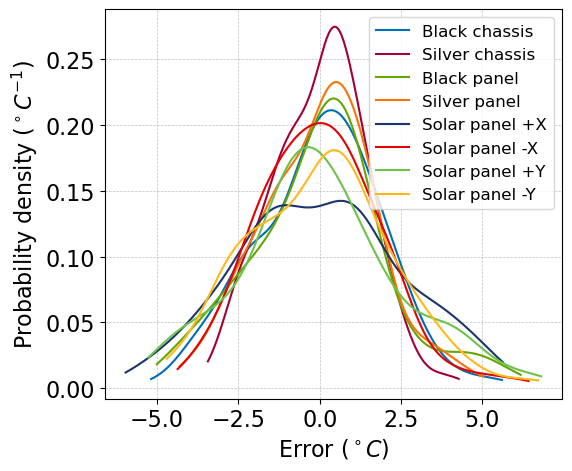

In [28]:
actual = test_df.iloc[:, -9:-1].to_numpy()
predicted = np.zeros(shape=actual.shape, dtype=np.float64)
for i in range(8):
    predicted[:, i] = fit_function(test_df["theta_T (deg)"].to_numpy(), *fit_params[i]) - 273.15

errors = actual - predicted

# print("Base errors:")
# print(f"mu = {np.nanmean(base_errors)}; sigma = {np.nanstd(base_errors)}")

print("Curve fit errors:")
print(f"mu = {np.nanmean(errors)}; sigma = {np.nanstd(errors)}")

labels = [
    "Black chassis",
    "Silver chassis",
    "Black panel",
    "Silver panel",
    "Solar panel +X",
    "Solar panel -X",
    "Solar panel +Y",
    "Solar panel -Y",
]
kde_vals, bins = kde(
    errors,
    plot_kde=False,
)
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
for i in range(8):
    ax.plot(bins[i], kde_vals[i], label=labels[i], color=plt_colors[i])
ax.set_xlabel(r"Error ($^\circ C$)")
ax.set_ylabel(r"Probability density ($^\circ C^{-1}$)")
ax.grid()
ax.legend(fontsize=12)
fig.savefig("../../report/images/chapter-5/funcube-curve-fit-error-kde.pdf")

In [22]:
res_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
res_model_layers[0] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[1] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[2] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[3] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[4] = {
    "type": "Dense",
    "units": 64,
    "activation": "relu",
}
res_model_layers[5] = {
    "type": "Dense",
    "units": 32,
    "activation": "relu",
}
res_model_layers[6] = {
    "type": "Dense",
    "units": 16,
    "activation": "relu",
}

res_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True,
    min_delta=1e-6,
)   # early stopping callback

## Residual models : all channels

In [23]:
def window_data_res_illumination_all_channels(df, base_window_size, base_model, res_window_size, check_continuous=True):
    df = df.copy()
    columns = np.concatenate(
        (
            ["theta_T"],
            ["black chassis in " + str(i) for i in range(res_window_size)],
            ["silver chassis in " + str(i) for i in range(res_window_size)],
            ["black panel in " + str(i) for i in range(res_window_size)],
            ["silver panel in " + str(i) for i in range(res_window_size)],
            ["solar panel +X in " + str(i) for i in range(res_window_size)],
            ["solar panel -X in " + str(i) for i in range(res_window_size)],
            ["solar panel +Y in " + str(i) for i in range(res_window_size)],
            ["solar panel -Y in " + str(i) for i in range(res_window_size)],
            ["black chassis pred"],
            ["silver chassis pred"],
            ["black panel pred"],
            ["silver panel pred"],
            ["solar panel +X pred"],
            ["solar panel -X pred"],
            ["solar panel +Y pred"],
            ["solar panel -Y pred"],
            ["black chassis out"],
            ["silver chassis out"],
            ["black panel out"],
            ["silver panel out"],
            ["solar panel +X out"],
            ["solar panel -X out"],
            ["solar panel +Y out"],
            ["solar panel -Y out"],
        )
    )

    window_df = pd.DataFrame(columns=columns, dtype=np.float64)
    illum_list = []

    with alive_bar(df.shape[0] - base_window_size, theme="classic", force_tty=True) as bar:
        for i in range(df.shape[0] - base_window_size):
            if check_continuous and (
                df.loc[i + base_window_size, "time (jd)"] - df.loc[i, "time (jd)"] > 1.25 * (i * 24 * 60)
            ):
                bar()
                continue

            window_df.loc[i, "theta_T"] = df.loc[i + base_window_size, "theta_T (deg)"]
            illumination = df.loc[i : i + base_window_size - 1, "illumination"].to_numpy()
            illum_list.append(illumination)
            # pred = base_model.predict(illumination.reshape(1, base_window_size, 1), verbose=0).flatten()[0]
            window_df.loc[i, "black chassis in 0":f"black chassis in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "black chassis temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "silver chassis in 0":f"silver chassis in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "silver chassis temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "black panel in 0":f"black panel in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "black panel temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "silver panel in 0":f"silver panel in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "silver panel temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel +X in 0":f"solar panel +X in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel +X temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel -X in 0":f"solar panel -X in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel -X temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel +Y in 0":f"solar panel +Y in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel +Y temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel -Y in 0":f"solar panel -Y in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel -Y temperature (deg C)"
            ].to_numpy()
            
            # window_df.loc[i, "black panel pred"] = pred
            # window_df.loc[i, "black panel out"] = df.loc[i + base_window_size, "black panel temperature (deg C)"] - pred
            bar()
            
    preds = base_model.predict(np.array(illum_list).reshape(-1, base_window_size, 1), verbose=0)
    window_df.loc[:, "black chassis pred":"solar panel -Y pred"] = preds
    
    for i, row in window_df.iterrows():
        window_df.loc[i, "black chassis out"] = df.loc[i + base_window_size, "black chassis temperature (deg C)"] - row["black chassis pred"]
        window_df.loc[i, "silver chassis out"] = df.loc[i + base_window_size, "silver chassis temperature (deg C)"] - row["silver chassis pred"]
        window_df.loc[i, "black panel out"] = df.loc[i + base_window_size, "black panel temperature (deg C)"] - row["black panel pred"]
        window_df.loc[i, "silver panel out"] = df.loc[i + base_window_size, "silver panel temperature (deg C)"] - row["silver panel pred"]
        window_df.loc[i, "solar panel +X out"] = df.loc[i + base_window_size, "solar panel +X temperature (deg C)"] - row["solar panel +X pred"]
        window_df.loc[i, "solar panel -X out"] = df.loc[i + base_window_size, "solar panel -X temperature (deg C)"] - row["solar panel -X pred"]
        window_df.loc[i, "solar panel +Y out"] = df.loc[i + base_window_size, "solar panel +Y temperature (deg C)"] - row["solar panel +Y pred"]
        window_df.loc[i, "solar panel -Y out"] = df.loc[i + base_window_size, "solar panel -Y temperature (deg C)"] - row["solar panel -Y pred"]

    x = np.zeros((window_df.shape[0], 8*(res_window_size+1)), dtype=np.float64)
    y = np.zeros((window_df.shape[0], 8), dtype=np.float64)

    x = window_df.iloc[:, 1:-8].to_numpy(dtype=np.float64)
    y = window_df.iloc[:, -8:].to_numpy(dtype=np.float64)

    return window_df, x, y

[========================================] 838/838 [100%] in 1.7s (484.87/s)                                            
[========================================] 138/138 [100%] in 0.3s (527.54/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 22ms/step - loss: 0.0054 - mean_absolute_error: 0.0485 - val_loss: 0.0017 - val_mean_absolute_error: 0.0330
Epoch 2/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0461 - val_loss: 0.0016 - val_mean_absolute_error: 0.0320
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0452 - val_loss: 0.0016 - val_mean_absolute_error: 0.0317
Epoch 4/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_absolute_error: 0.0442 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311
Epoch 5/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0433 

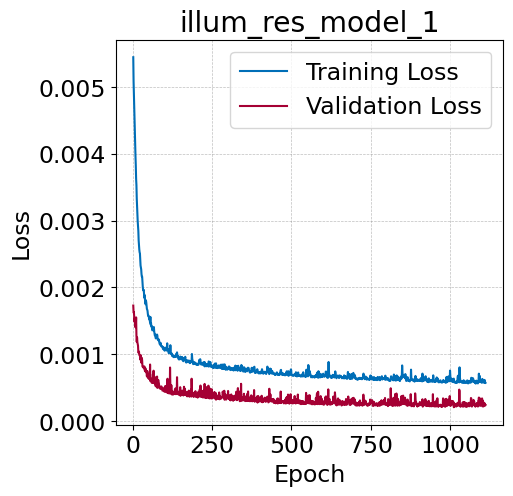

[========================================] 838/838 [100%] in 1.8s (477.67/s)                                            
[========================================] 138/138 [100%] in 0.3s (521.35/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 20ms/step - loss: 0.0053 - mean_absolute_error: 0.0467 - val_loss: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 2/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0455 - val_loss: 0.0016 - val_mean_absolute_error: 0.0312
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_absolute_error: 0.0449 - val_loss: 0.0015 - val_mean_absolute_error: 0.0307
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0443 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0437 

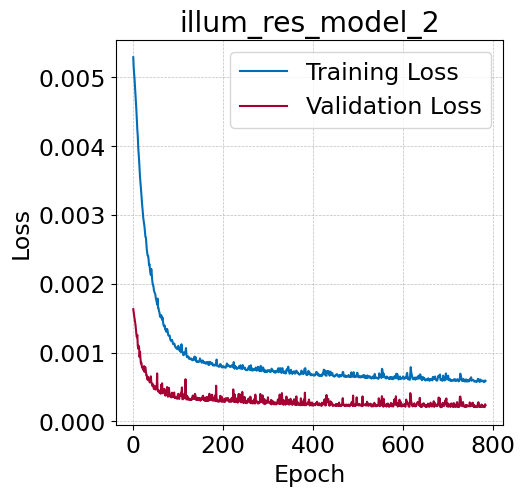

[========================================] 838/838 [100%] in 1.7s (487.03/s)                                            
[========================================] 138/138 [100%] in 0.3s (580.27/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 21ms/step - loss: 0.0069 - mean_absolute_error: 0.0571 - val_loss: 0.0020 - val_mean_absolute_error: 0.0351
Epoch 2/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0480 - val_loss: 0.0018 - val_mean_absolute_error: 0.0331
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0466 - val_loss: 0.0017 - val_mean_absolute_error: 0.0325
Epoch 4/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0462 - val_loss: 0.0017 - val_mean_absolute_error: 0.0322
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0458 

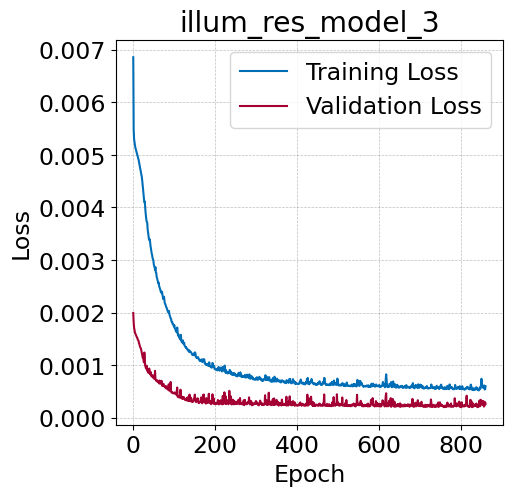

[========================================] 838/838 [100%] in 1.7s (488.10/s)                                            
[========================================] 138/138 [100%] in 0.3s (533.96/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 21ms/step - loss: 0.0055 - mean_absolute_error: 0.0486 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 2/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0456 - val_loss: 0.0017 - val_mean_absolute_error: 0.0321
Epoch 3/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0450 - val_loss: 0.0016 - val_mean_absolute_error: 0.0316
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0443 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310
Epoch 5/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_absolute_error: 0.0436 

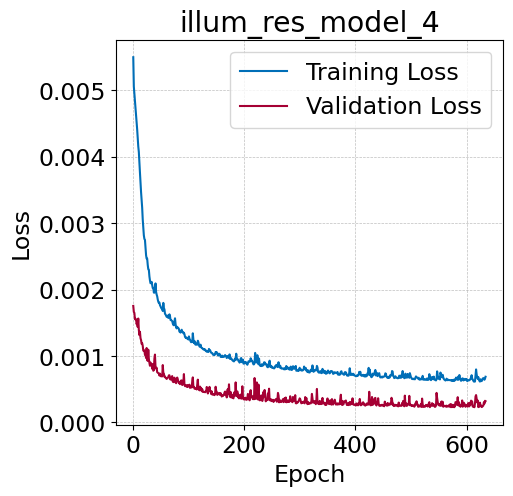

[========================================] 838/838 [100%] in 1.8s (468.87/s)                                            
[========================================] 138/138 [100%] in 0.3s (531.89/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 22ms/step - loss: 0.0065 - mean_absolute_error: 0.0542 - val_loss: 0.0018 - val_mean_absolute_error: 0.0349
Epoch 2/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0479 - val_loss: 0.0017 - val_mean_absolute_error: 0.0331
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0464 - val_loss: 0.0017 - val_mean_absolute_error: 0.0330
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0453 - val_loss: 0.0016 - val_mean_absolute_error: 0.0312
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0446 

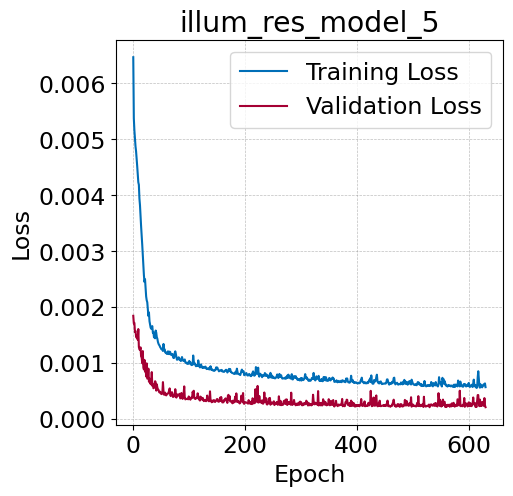

[========================================] 838/838 [100%] in 1.9s (447.87/s)                                            
[========================================] 138/138 [100%] in 0.3s (491.69/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 20ms/step - loss: 0.0062 - mean_absolute_error: 0.0529 - val_loss: 0.0019 - val_mean_absolute_error: 0.0339
Epoch 2/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0467 - val_loss: 0.0016 - val_mean_absolute_error: 0.0316
Epoch 3/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0457 - val_loss: 0.0016 - val_mean_absolute_error: 0.0318
Epoch 4/3500
9/9 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0454 - val_loss: 0.0015 - val_mean_absolute_error: 0.0310
Epoch 5/3500
9/9 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0447 

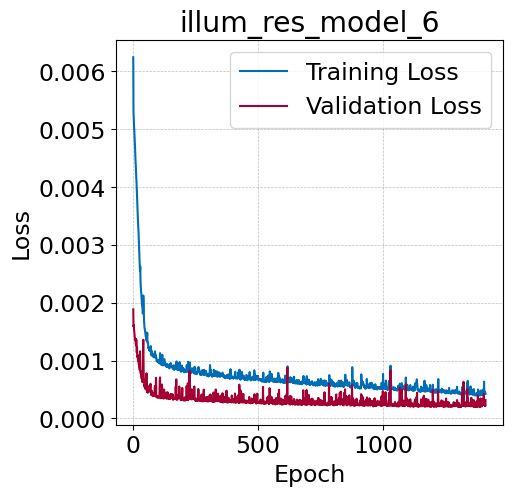

[========================================] 838/838 [100%] in 1.7s (495.55/s)                                            
[========================================] 138/138 [100%] in 0.3s (795.24/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 20ms/step - loss: 0.0060 - mean_absolute_error: 0.0519 - val_loss: 0.0016 - val_mean_absolute_error: 0.0320
Epoch 2/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0464 - val_loss: 0.0017 - val_mean_absolute_error: 0.0329
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0459 - val_loss: 0.0017 - val_mean_absolute_error: 0.0325
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0457 - val_loss: 0.0017 - val_mean_absolute_error: 0.0325
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0452 

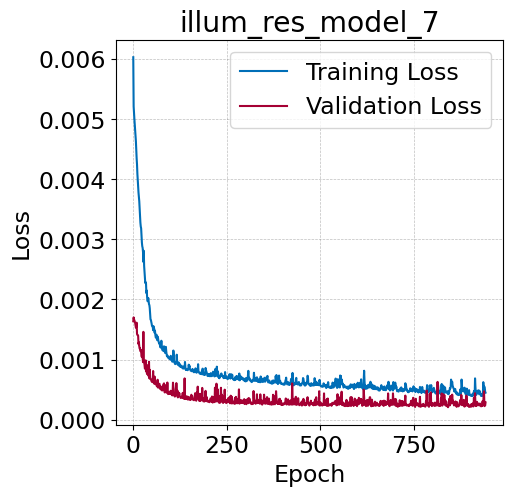

[========================================] 838/838 [100%] in 1.7s (495.06/s)                                            
[========================================] 138/138 [100%] in 0.3s (515.32/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 23ms/step - loss: 0.0058 - mean_absolute_error: 0.0505 - val_loss: 0.0018 - val_mean_absolute_error: 0.0333
Epoch 2/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0466 - val_loss: 0.0017 - val_mean_absolute_error: 0.0328
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0459 - val_loss: 0.0016 - val_mean_absolute_error: 0.0320
Epoch 4/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0456 - val_loss: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 5/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0454 

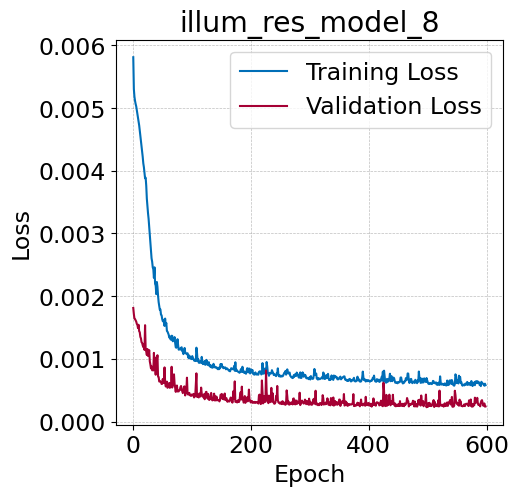

[========================================] 838/838 [100%] in 1.7s (486.77/s)                                            
[========================================] 138/138 [100%] in 0.3s (522.56/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 20ms/step - loss: 0.0083 - mean_absolute_error: 0.0647 - val_loss: 0.0022 - val_mean_absolute_error: 0.0370
Epoch 2/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_error: 0.0491 - val_loss: 0.0018 - val_mean_absolute_error: 0.0335
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0464 - val_loss: 0.0018 - val_mean_absolute_error: 0.0334
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0460 - val_loss: 0.0017 - val_mean_absolute_error: 0.0329
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0455 

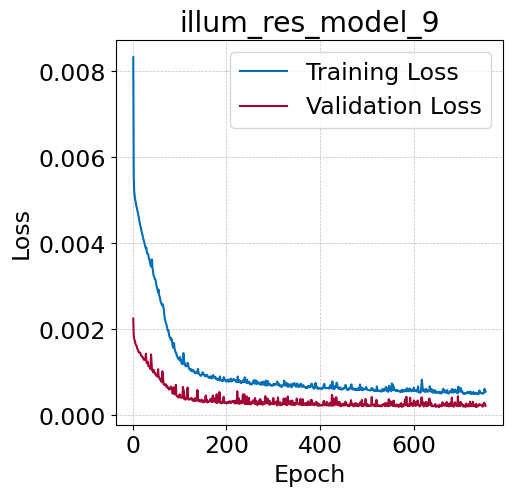

[========================================] 838/838 [100%] in 2.0s (430.97/s)                                            
[========================================] 138/138 [100%] in 0.3s (473.21/s)                                            
Epoch 1/3500
9/9 [==============================] - 2s 23ms/step - loss: 0.0061 - mean_absolute_error: 0.0514 - val_loss: 0.0018 - val_mean_absolute_error: 0.0339
Epoch 2/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0465 - val_loss: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 3/3500
9/9 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0456 - val_loss: 0.0016 - val_mean_absolute_error: 0.0318
Epoch 4/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0452 - val_loss: 0.0016 - val_mean_absolute_error: 0.0316
Epoch 5/3500
9/9 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0449 

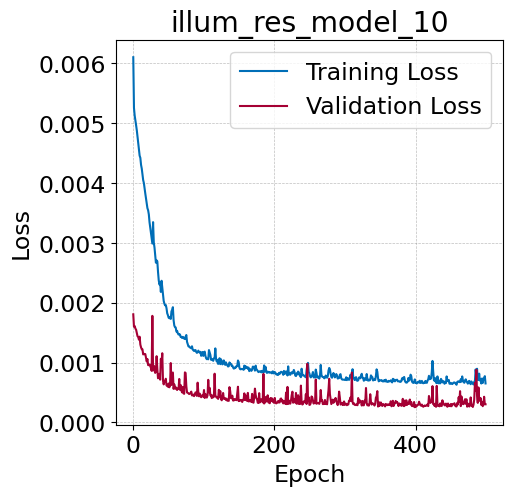

In [24]:
res_window_sizes = np.arange(1, 11, 1)
res_models_all_channel = []

for res_window_size in res_window_sizes:
    res_train_window_df, res_train_x, res_train_y = window_data_res_illumination_all_channels(train_norm_df, 96, base_model_all_channel.model, res_window_size)
    res_test_window_df, res_test_x, res_test_y = window_data_res_illumination_all_channels(test_norm_df, 96, base_model_all_channel.model, res_window_size)
    
    res_model = Model(res_train_x, res_train_y, res_test_x, res_test_y, f"illum_res_model_{res_window_size}")
    
    res_model.create_model(
        res_model_layers,
        tf.keras.optimizers.Adam(learning_rate=1e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(8*(res_window_size+1),),
        output_shape=8,
    )
    
    res_model.train_model(3500, res_early_stopping)
    res_models_all_channel.append(res_model.model)
            

[>                                       ] - 2/138 [1%] in 0s (~0s, 631.2/s) 

[========================================] 138/138 [100%] in 0.2s (572.28/s)                                            
[========================================] 138/138 [100%] in 0.4s (485.53/s)                                            
Window Size: 1


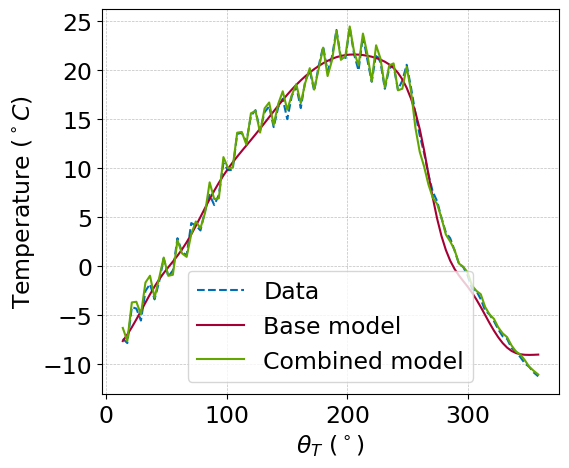

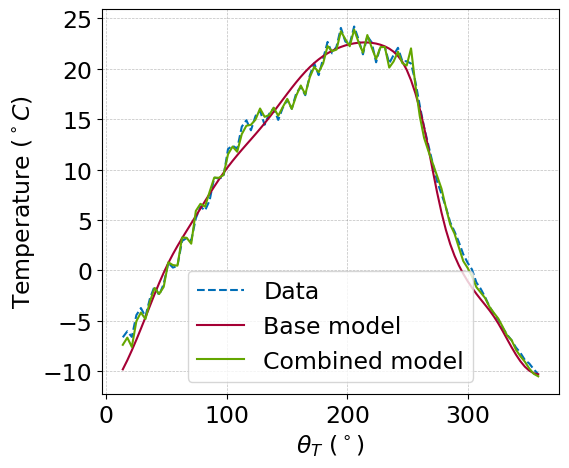

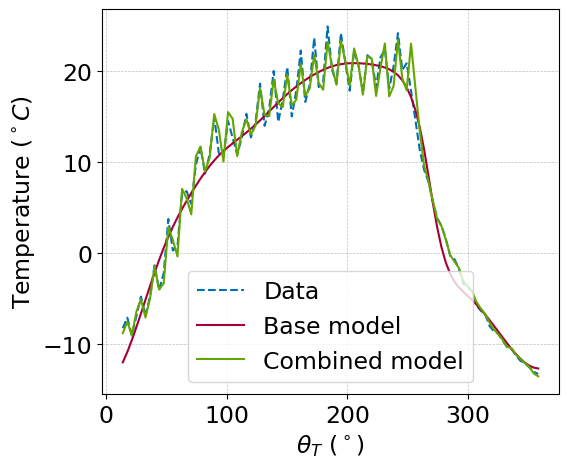

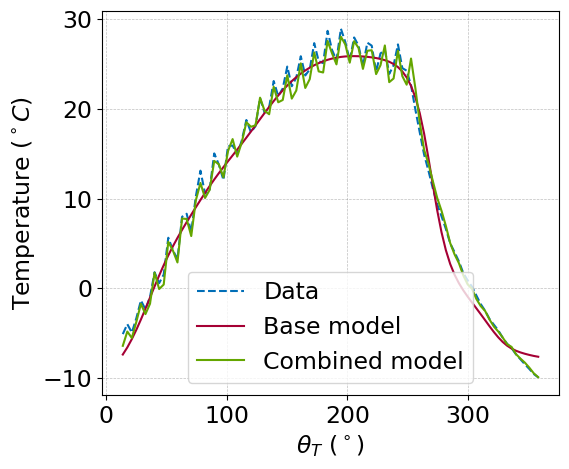

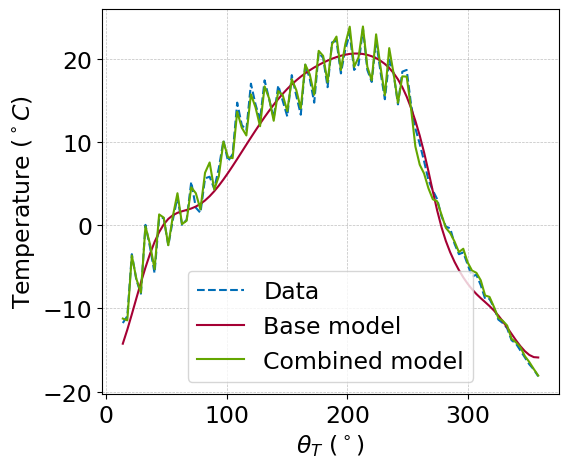

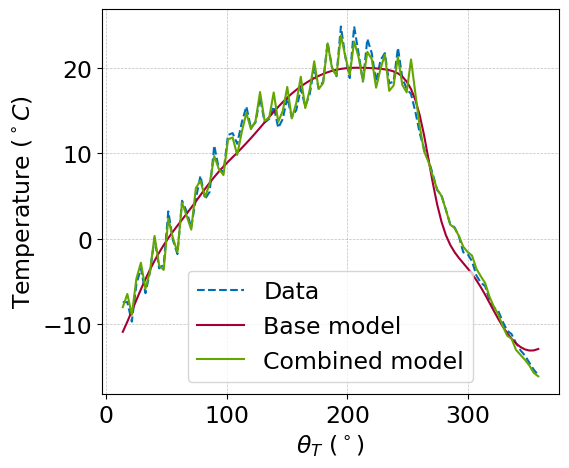

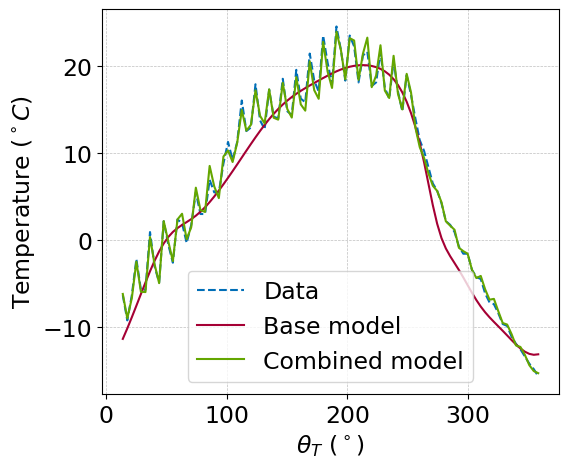

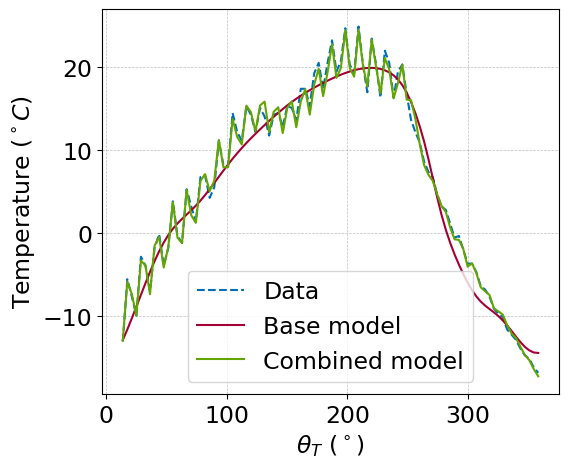

[========================================] 138/138 [100%] in 0.3s (586.72/s)                                            
[========================================] 138/138 [100%] in 0.3s (478.85/s)                                            
Window Size: 2
[========================================] 138/138 [100%] in 0.3s (457.77/s)                                            
[========================================] 138/138 [100%] in 0.3s (497.95/s)                                            
Window Size: 3
[========================================] 138/138 [100%] in 0.2s (661.14/s)                                            
[========================================] 138/138 [100%] in 0.3s (492.45/s)                                            
Window Size: 4
[========================================] 138/138 [100%] in 0.3s (653.86/s)                                            
[========================================] 138/138 [100%] in 0.3s (531.03/s)                                

In [28]:
errors = []
for idx, res_window_size in enumerate(res_window_sizes):
    res_model = res_models_all_channel[idx]

    test_window_df, test_x, test_y = window_data_base_illumination_all_channels(test_norm_df, 96)
    test_window_res_df, test_res_x, test_res_y = window_data_res_illumination_all_channels(test_norm_df, 96, base_model_all_channel.model, res_window_size)

    theta_T = test_window_df.iloc[:, 0].to_numpy()
    actual = denormalize_temperature(test_y, norm_limits)
    base_preds = base_model_all_channel.model.predict(test_x, verbose=0)
    res_preds = res_model.predict(test_res_x, verbose=0)
    combined_preds = denormalize_temperature(base_preds + res_preds, norm_limits)
    base_preds = denormalize_temperature(base_preds, norm_limits)
    
    res_errors = (actual - combined_preds)

    errors.append(res_errors)
    
    try:
        start_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][94]].index[0]
    except:
        start_index = 0
            
    end_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][190]].index[0]


    print(f"Window Size: {res_window_size}")
    if res_window_size == 1:
        for idx in range(8):
            fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
            ax.plot(theta_T[start_index:end_index], actual[start_index:end_index, idx], color=plt_colors[0], linestyle="--", label="Data")
            ax.plot(theta_T[start_index:end_index], base_preds[start_index:end_index, idx], color=plt_colors[1], label="Base model")
            ax.plot(theta_T[start_index:end_index], combined_preds[start_index:end_index, idx], color=plt_colors[2], label="Combined model")
            ax.grid()
            ax.legend()
            ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
            ax.set_ylabel(r"Temperature ($^\circ C$)")
            # fig.savefig(f"../../report/images/chapter-4/funcube-all-channel-illumination-combined-1-{titles[idx]}.pdf")
        plt.show()
        
    # if res_window_size == 5:
    #     fig, ax = plt.subplots(2, 4, figsize=(24, 10), tight_layout=True)
    #     for idx in range(8):
    #         fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    #         # i, j = np.unravel_index(idx, (2, 4))
    #         ax.plot(theta_T[start_index:end_index], actual[start_index:end_index, idx], color=plt_colors[0], linestyle="--")
    #         ax.plot(theta_T[start_index:end_index], base_preds[start_index:end_index, idx], color=plt_colors[1])
    #         ax.plot(theta_T[start_index:end_index], combined_preds[start_index:end_index, idx], color=plt_colors[2])
    #         ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    #         ax.set_ylabel(r"Temperature ($^\circ C$)")
    #         ax.grid()
        
    # fig.legend(["Data", "Base Model", "Combined Model"], loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.04), bbox_transform=fig.transFigure)
    plt.show()
    

[========================================] 138/138 [100%] in 0.3s (514.81/s)                                            
[========================================] 138/138 [100%] in 0.3s (450.70/s)                                            


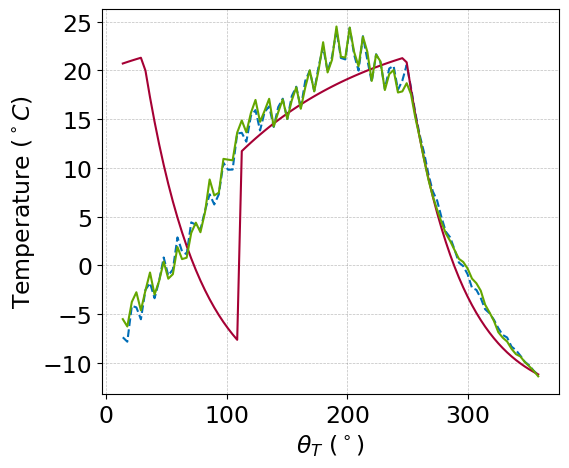

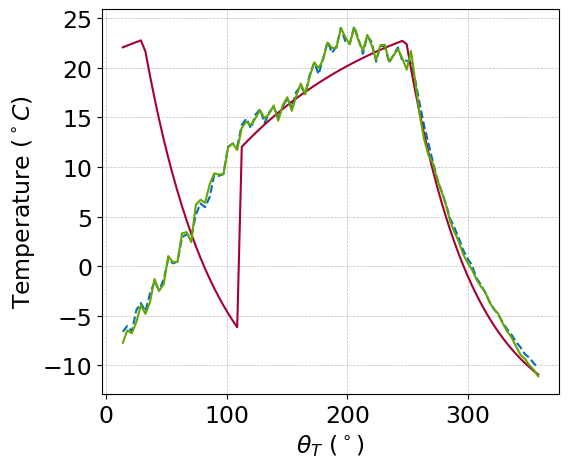

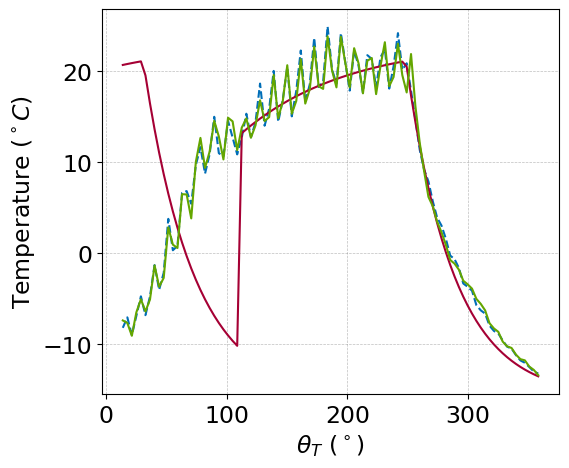

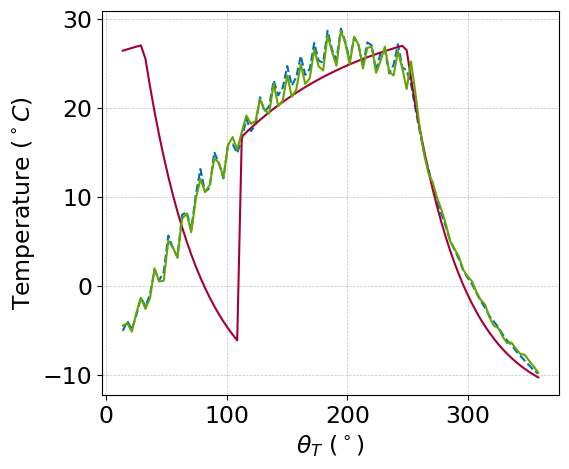

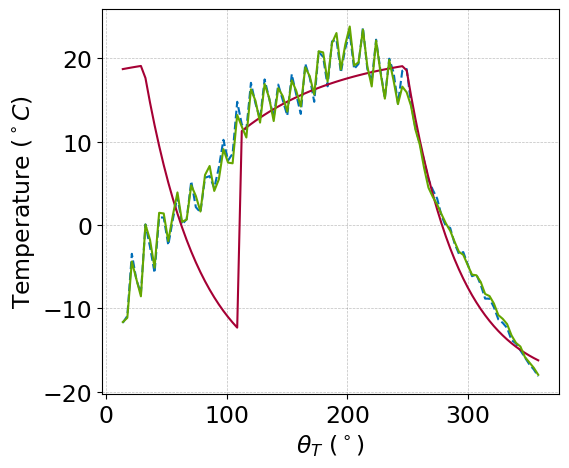

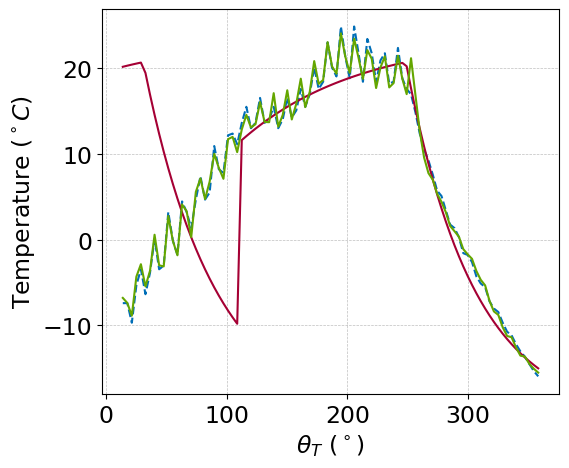

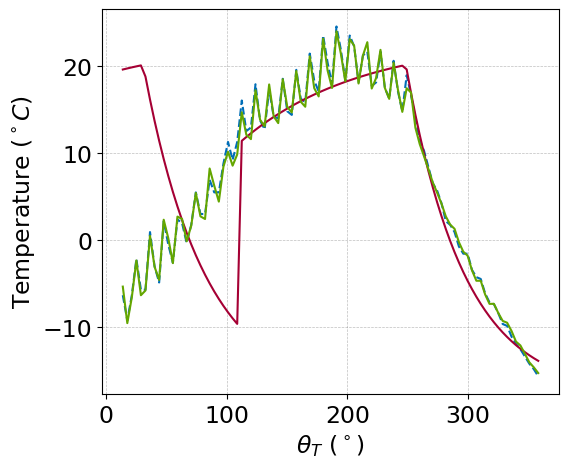

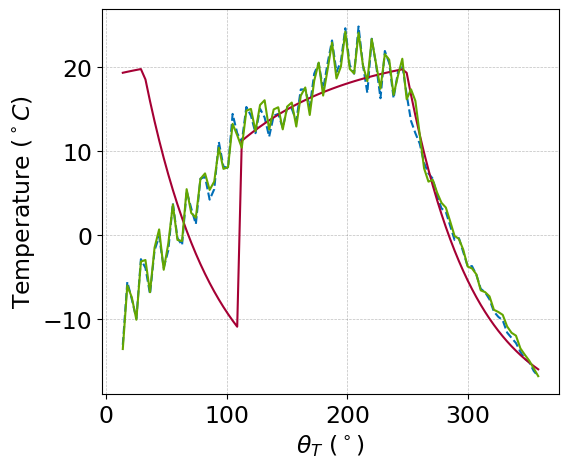

In [26]:
titles = [
    "black-chassis",
    "silver-chassis",
    "black-panel",
    "silver-panel",
    "+X solar-panel",
    "-X solar-panel",
    "+Y solar-panel",
    "-Y solar-panel",
]
res_model = res_models_all_channel[4]
res_window_size = 5

test_window_df, test_x, test_y = window_data_base_illumination_all_channels(test_norm_df, 96)
test_window_res_df, test_res_x, test_res_y = window_data_res_illumination_all_channels(test_norm_df, 96, base_model_all_channel.model, res_window_size)

theta_T = test_window_df.iloc[:, 0].to_numpy()
actual = denormalize_temperature(test_y, norm_limits)
base_preds = base_model_all_channel.model.predict(test_x, verbose=0)
res_preds = res_model.predict(test_res_x, verbose=0)
combined_preds = denormalize_temperature(base_preds + res_preds, norm_limits)
base_preds = denormalize_temperature(base_preds, norm_limits)

res_errors = (actual - combined_preds)

errors.append(res_errors)

try:
    start_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][94]].index[0]
except:
    start_index = 0
        
end_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][190]].index[0]

for idx in range(8):
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index, idx], color=plt_colors[0], label="Data", linestyle="--")
    ax.plot(theta_T[start_index:end_index], predicted[start_index:end_index, idx], color=plt_colors[1], label="Predicted")
    ax.plot(theta_T[start_index:end_index], combined_preds[start_index:end_index, idx], color=plt_colors[2], label="Residual")
    ax.grid()
    ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    plt.show()
    
    # fig.savefig(f"../../report/images/chapter-4/funcube-all-channel-illumination-combined-5-{titles[idx]}.pdf")

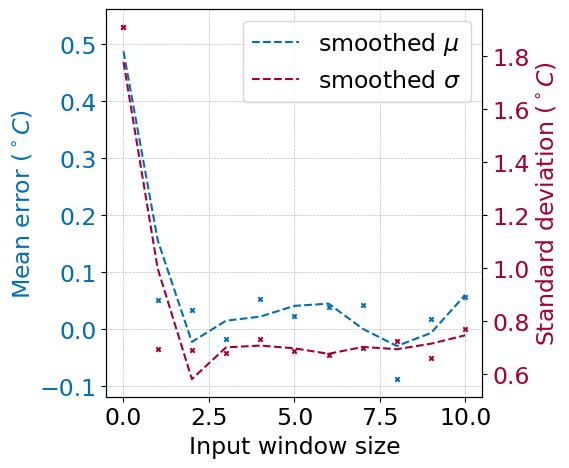

In [29]:
stat_errors = np.array(errors)

stat_errors = np.concatenate([base_errors.reshape(1, base_errors.shape[0], base_errors.shape[1]), stat_errors], axis=0)
steps = np.arange(0, 11)
mu = np.mean(stat_errors, axis=(1, 2))
sigma = np.std(stat_errors, axis=(1, 2))

fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(steps, mu, s=10, color=plt_colors[0], marker="x")
# smoothed line
ax.plot(steps, savgol_filter(mu, 5, 2), color=plt_colors[0], linestyle="--", label="smoothed $\mu$")
twin_ax = ax.twinx()
twin_ax.scatter(steps, sigma, s=10, color=plt_colors[1], marker="x")
# smoothed line
twin_ax.plot(steps, savgol_filter(sigma, 5, 2), color=plt_colors[1], linestyle="--", label="smoothed $\sigma$")

# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax.set_ylabel(r"Mean error ($^\circ C$)", color=plt_colors[0])
twin_ax.set_ylabel(r"Standard deviation ($^\circ C$)", color=plt_colors[1])
ax.tick_params(axis="y", labelcolor=plt_colors[0])
twin_ax.tick_params(axis="y", labelcolor=plt_colors[1])
ax.set_xlabel("Input window size")
ax.grid()

# fig.savefig("../../report/images/chapter-4/funcube-all-channel-illumination-combined-error.pdf")

plt.show()

In [37]:
print(mu[0], mu[5], mu[10])
print(sigma[0], sigma[5], sigma[10])

0.5313661786587568 0.02367635371911262 0.05731172116133416
1.9121226614982938 0.6877675198069291 0.7691915987857579


In [36]:
anomaly_base_df, anomaly_base_x, anomaly_base_y = window_data_base_illumination_all_channels(anomaly_norm_df, 96)
theta_T = anomaly_base_df["theta_T"].to_numpy()
actual = denormalize_temperature(anomaly_base_y, norm_limits)
base_preds = base_model_all_channel.model.predict(anomaly_base_x, verbose=0)
try:
    start_index = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_df["theta_T (deg)"][127]].index[0]
except:
    start_index = 0
end_index = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_df["theta_T (deg)"][221]].index[0]

anomaly_start_theta_T = anomaly_df["theta_T (deg)"][143]
anomaly_end_theta_T = anomaly_df["theta_T (deg)"][181]
anomaly_start_idx = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_start_theta_T].index[0]
anomaly_end_idx = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_end_theta_T].index[0]

base_errors = actual - denormalize_temperature(base_preds, norm_limits)

print(f"{np.mean(base_errors[start_index:anomaly_start_idx])}, {np.mean(base_errors[anomaly_start_idx:anomaly_end_idx])}, {np.mean(base_errors[anomaly_end_idx:end_index])}")
print(f"{np.std(base_errors[start_index:anomaly_start_idx])}, {np.std(base_errors[anomaly_start_idx:anomaly_end_idx])}, {np.std(base_errors[anomaly_end_idx:end_index])}")

[========================================] 129/129 [100%] in 0.2s (552.79/s)                                            
0.3955012157559395, -11.248221621262402, -0.13983110105991353
1.9998315167244347, 5.417386416975341, 1.4241232597581326


In [43]:
titles

['black-chassis',
 'silver-chassis',
 'black-panel',
 'silver-panel',
 '+X solar-panel',
 '-X solar-panel',
 '+Y solar-panel',
 '-Y solar-panel']

[>                                       ] - 2/129 [2%] in 0s (~0s, 378.9/s) 

[========================================] 129/129 [100%] in 0.3s (429.51/s)                                            
[========================================] 129/129 [100%] in 0.3s (499.70/s)                                            
[========================================] 129/129 [100%] in 0.3s (513.22/s)                                            
[========================================] 129/129 [100%] in 0.3s (428.86/s)                                            
[========================================] 129/129 [100%] in 0.2s (659.96/s)                                            
[========================================] 129/129 [100%] in 0.3s (447.84/s)                                            
[========================================] 129/129 [100%] in 0.2s (657.43/s)                                            
[========================================] 129/129 [100%] in 0.3s (371.42/s)                                            
[===============================

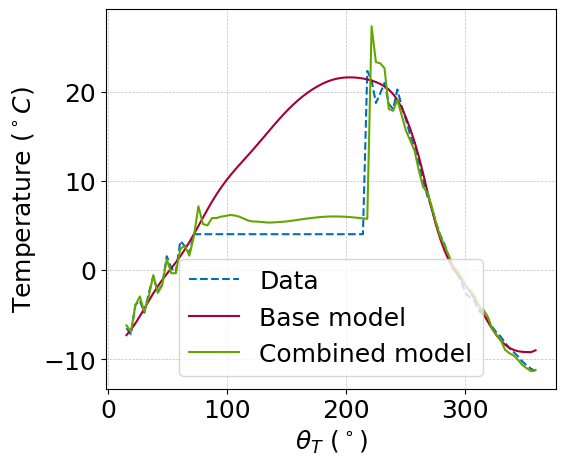

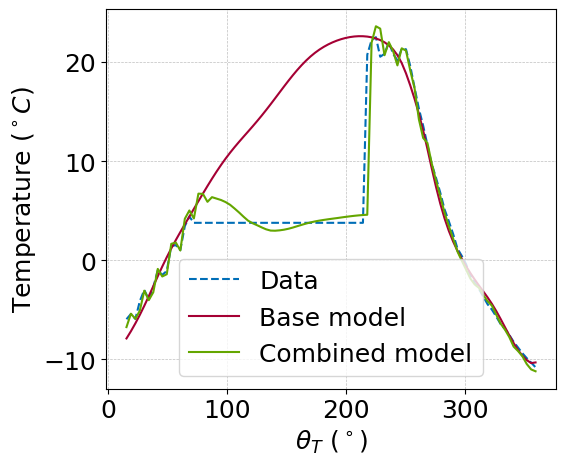

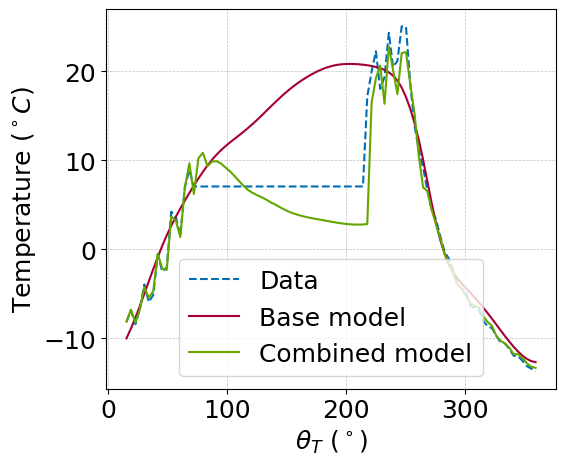

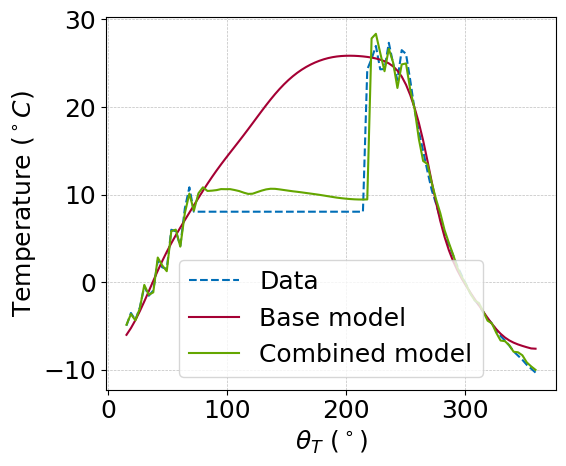

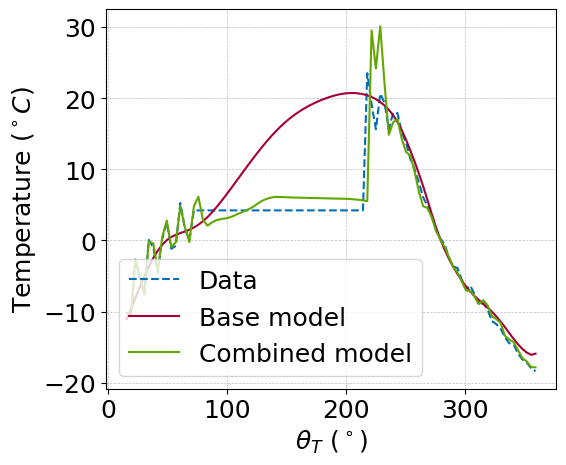

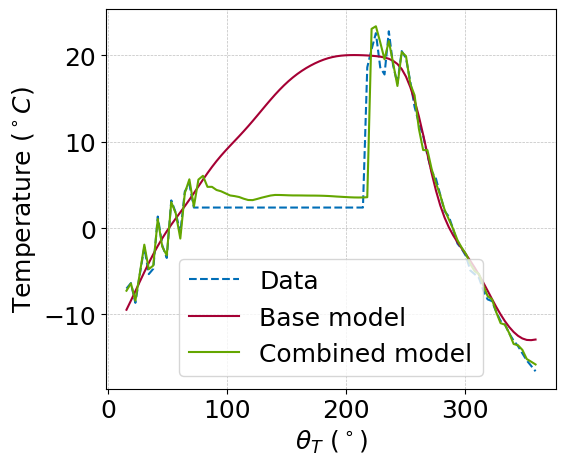

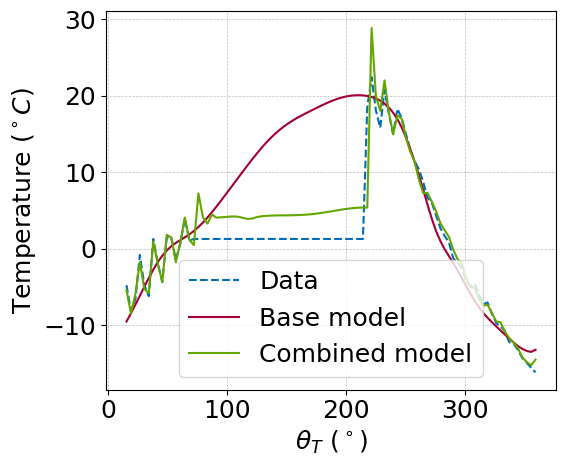

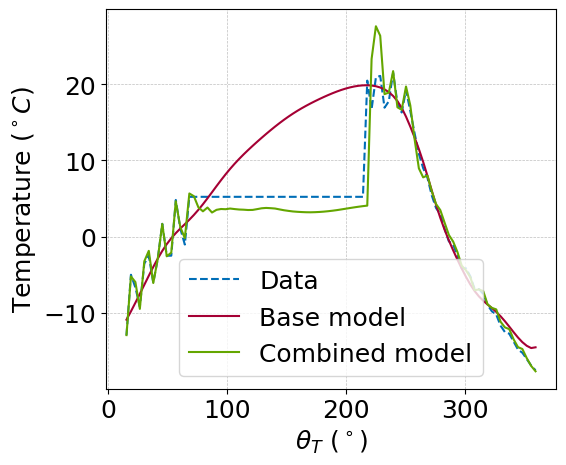

In [45]:
anomaly_mu = np.zeros((len(res_window_sizes), 3))
anomaly_sigma = np.zeros((len(res_window_sizes), 3))
plt.rcParams.update({'font.size': 18})
for idx, res_window_size in enumerate(res_window_sizes):
    res_model = res_models_all_channel[idx]
    res_window_size = res_window_sizes[idx]

    anomaly_base_df, anomaly_base_x, anomaly_base_y = window_data_base_illumination_all_channels(anomaly_norm_df, 96)
    anomaly_res_df, anomaly_res_x, anomaly_res_y = window_data_res_illumination_all_channels(anomaly_norm_df, 96, base_model_all_channel.model, res_window_size)

    theta_T = anomaly_base_df["theta_T"].to_numpy()
    actual = denormalize_temperature(anomaly_base_y, norm_limits)
    base_preds = base_model_all_channel.model.predict(anomaly_base_x, verbose=0)
    res_preds = res_model.predict(anomaly_res_x, verbose=0)
    combined_preds = base_preds + res_preds
    base_preds = denormalize_temperature(base_preds, norm_limits)
    combined_preds = denormalize_temperature(combined_preds, norm_limits)

    try:
        start_index = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_df["theta_T (deg)"][127]].index[0]
    except:
        start_index = 0
    end_index = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_df["theta_T (deg)"][221]].index[0]
    
    anomaly_start_theta_T = anomaly_df["theta_T (deg)"][143]
    anomaly_end_theta_T = anomaly_df["theta_T (deg)"][181]
    anomaly_start_idx = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_start_theta_T].index[0]
    anomaly_end_idx = anomaly_base_df[anomaly_base_df["theta_T"] == anomaly_end_theta_T].index[0]
    
    combined_error = actual - combined_preds
    
    anomaly_mu[idx, 0] = np.mean(combined_error[start_index:anomaly_start_idx])
    anomaly_mu[idx, 1] = np.mean(combined_error[anomaly_start_idx:anomaly_end_idx])
    anomaly_mu[idx, 2] = np.mean(combined_error[anomaly_end_idx:end_index])
    anomaly_sigma[idx, 0] = np.std(combined_error[start_index:anomaly_start_idx])
    anomaly_sigma[idx, 1] = np.std(combined_error[anomaly_start_idx:anomaly_end_idx])
    anomaly_sigma[idx, 2] = np.std(combined_error[anomaly_end_idx:end_index])
    
    if res_window_size == 5:
        for i in range(8):
            fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
            ax.plot(theta_T[start_index:end_index], actual[start_index:end_index, i], color=plt_colors[0], linestyle="--", label="Data")
            ax.plot(theta_T[start_index:end_index], base_preds[start_index:end_index, i], color=plt_colors[1], label="Base model")
            ax.plot(theta_T[start_index:end_index], combined_preds[start_index:end_index, i], color=plt_colors[2], label="Combined model")
            ax.grid()
            ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
            ax.set_ylabel(r"Temperature ($^\circ C$)")
            ax.legend()
            fig.savefig(f"../../report/images/chapter-4/funcube-all-channel-combined-anomaly-5-{titles[i]}.pdf")
    
    # fig, ax = plt.subplots(2, 4, figsize=(24, 10), tight_layout=True)
    # for idx in range(8):
    #     i, j = np.unravel_index(idx, (2, 4))
    #     ax[i, j].plot(theta_T[start_index:end_index], actual[start_index:end_index, idx], color=plt_colors[0], linestyle="--")
    #     ax[i, j].plot(theta_T[start_index:end_index], base_preds[start_index:end_index, idx], color=plt_colors[1])
    #     ax[i, j].plot(theta_T[start_index:end_index], combined_preds[start_index:end_index, idx], color=plt_colors[2])
    #     ax[i, j].set_xlabel(r"$\theta_T$ ($^\circ$)")
    #     ax[i, j].set_ylabel(r"Temperature ($^\circ C$)")
    #     ax[i, j].grid()
        
    # fig.legend(["Data", "Base Model", "Combined Model"], loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.01), bbox_transform=fig.transFigure)
    # plt.show()

In [39]:
for idx in range(len(res_window_sizes)):
    print(f"{res_window_sizes[idx]}: {anomaly_mu[idx, 0]}, {anomaly_mu[idx, 1]}, {anomaly_mu[idx, 2]}")
    print(f"{res_window_sizes[idx]}: {anomaly_sigma[idx, 0]}, {anomaly_sigma[idx, 1]}, {anomaly_sigma[idx, 2]}")

1: 0.08146743178367616, -0.8439421319961552, 0.4887160071134569
1: 0.37338489985013285, 2.7385986163764047, 2.5192667643194477
2: 0.05000620782375337, -0.08868483292429101, 0.4004925557374956
2: 0.43497206481817, 2.0224359038966275, 2.717902982621934
3: 0.05710013657808305, -0.26414041569358454, 0.32085056388378164
3: 0.3869762058481276, 2.61148883306391, 2.853349759691896
4: 0.06838047206401826, -0.3208224627846169, 0.4176410236358644
4: 0.5257446062862045, 2.3625561848046277, 2.871923918017244
5: 0.0016023114323616139, -0.8592620001341171, 0.1743982353210451
5: 0.3740384573142643, 1.9847910134563547, 2.88350375474259
6: 0.08968137651681901, -0.4058890950052365, 0.32823656582832356
6: 0.38471150363205225, 2.41475261095242, 2.5814142284066075
7: -0.008452410995960224, -1.2005586604068157, 0.44428176367282884
7: 0.3601841884411991, 2.5086555662412926, 2.380053425857788
8: 0.002272692322731029, -2.6189933869713236, -0.21164582586288438
8: 0.36951244793041577, 2.261913108426579, 2.4974291